# CVEs Forecast by Exploit Tag

The main purpose of this analysis is to forecast CVEs by Exploit Tag.

## Setup notebook

This code will setup notebook:

In [1]:
import os
import warnings
import logging

# Load env variables
env_properties = {}

files = [
    f"../env/env.properties",
    f"../env/env.secrets"
]

for file in files:
    with open(file, "r") as f:
        for line in f:
            line = line.rstrip()

            if "=" not in line:
                continue
            if line.startswith("#"):
                continue

            k, v = line.split("=", 1)
            env_properties[k] = v

    for key, value in env_properties.items():
        os.environ[str(key)] = str(value)

warnings.filterwarnings('ignore')
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

os.chdir("../app")

Now fill variables with desired values:

In [2]:
os.environ["LOG_LEVEL"] = "ERROR"
os.environ["REPOSITORY_DATA_SUFFIX"] = "_20240815"
MINIMUM_CONFIDENCE_THRESHOLD = 0.7

## Classifying CVEs by Exploit Tag

### CVE Data

Here is an initial analysis of CVE Data from official repository:

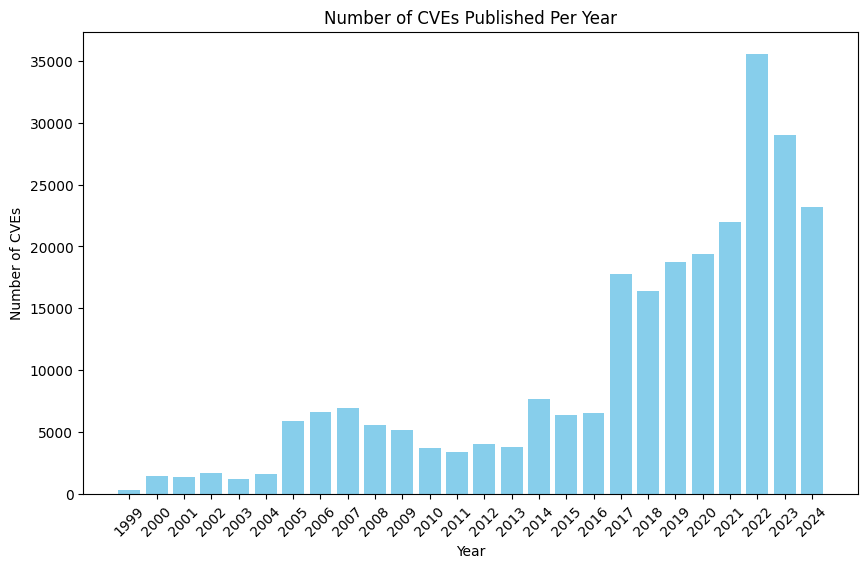

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from main import CVES_WITH_EXPLOIT_TAG_COLLECTION
from src.infrastructure.mongodb_cve_repository import MongoDBCVERepository
import seaborn as sns

cves_with_exploit_tag_repository = MongoDBCVERepository(collection_name=CVES_WITH_EXPLOIT_TAG_COLLECTION)
cves = cves_with_exploit_tag_repository.find_all()
df = pd.DataFrame(list(cves))

grouped_df = (
    df.groupby(df["date_published"].dt.to_period("Y"))
    .size()
    .reset_index(name="count")
)

grouped_df['date_published'] = grouped_df['date_published'].astype(str)

plt.figure(figsize=(10, 6))
plt.bar(grouped_df['date_published'], grouped_df['count'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of CVEs')
plt.title('Number of CVEs Published Per Year')
plt.xticks(rotation=45)
plt.show()

### First iteration: Exploit Tag from ExploitDB
As a first iteration, Exploit Tag is obtained from ExploitDB.

This is the result:

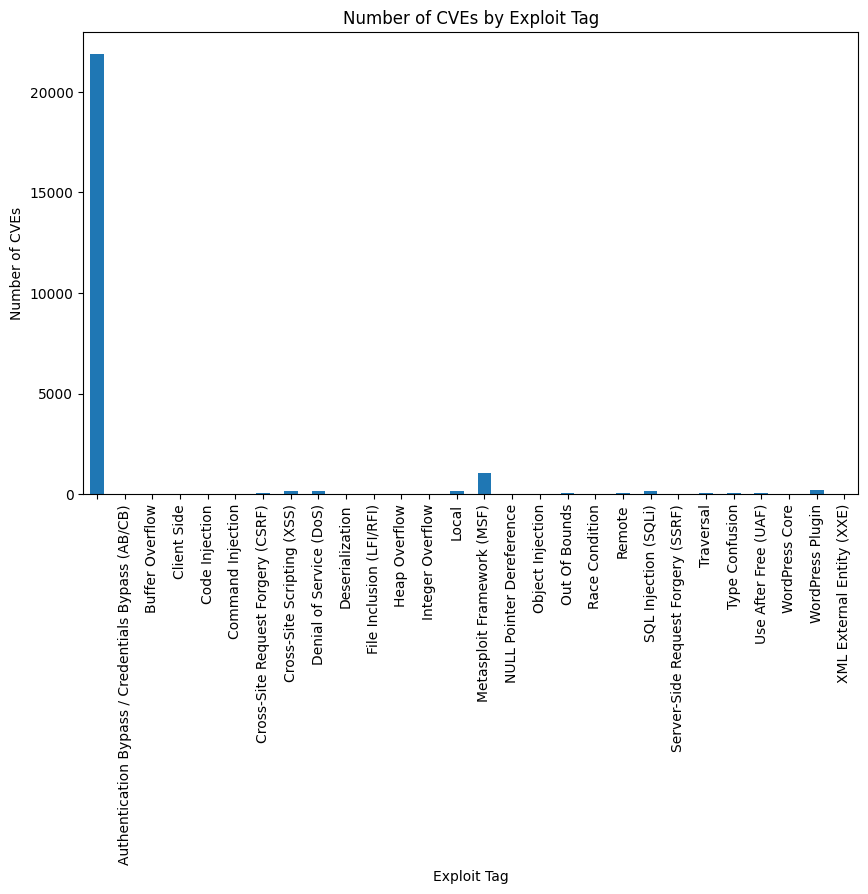

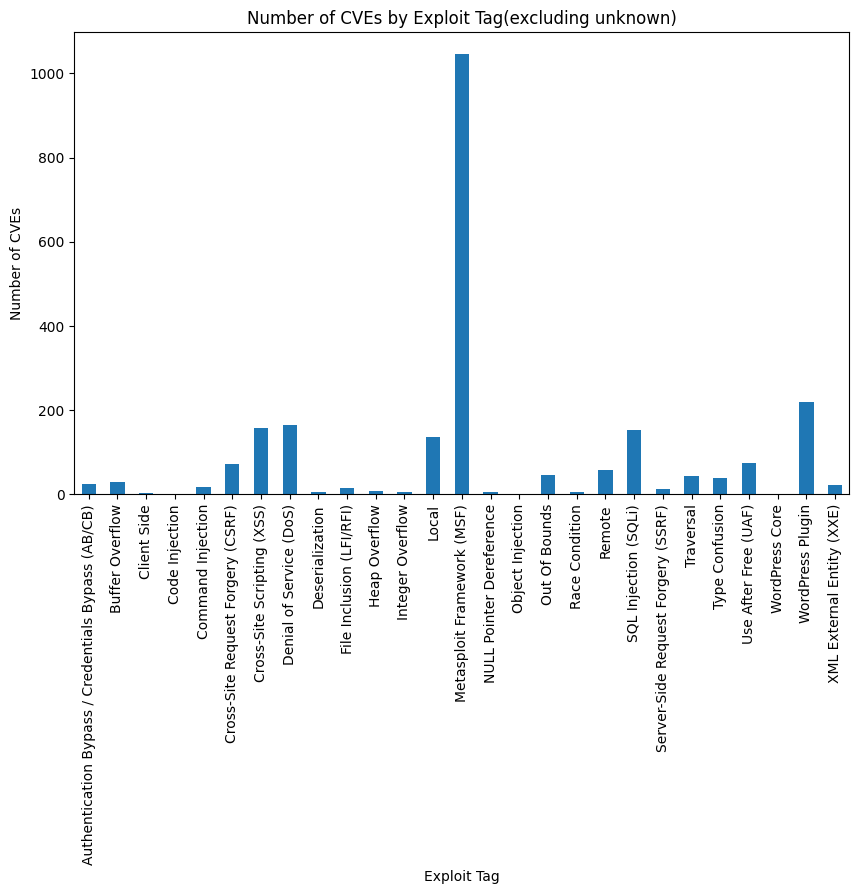

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

from main import CVES_WITH_EXPLOIT_TAG_COLLECTION
from src.infrastructure.mongodb_cve_repository import MongoDBCVERepository

cves_with_exploit_tag_repository = MongoDBCVERepository(collection_name=CVES_WITH_EXPLOIT_TAG_COLLECTION)
cves = cves_with_exploit_tag_repository.find_all()
df = pd.DataFrame(list(cves))

exploit_counts = df.groupby('exploit_tag').size()

plt.figure(figsize=(10, 6))
exploit_counts.plot(kind='bar')
plt.xlabel('Exploit Tag')
plt.ylabel('Number of CVEs')
plt.title('Number of CVEs by Exploit Tag')
plt.show()

df_filtered = df[(~df['exploit_tag'].isna()) & (df['exploit_tag'] != "") & (df['exploit_tag'] != "unknown")]

exploit_counts_filtered = df_filtered.groupby('exploit_tag').size()

plt.figure(figsize=(10, 6))
exploit_counts_filtered.plot(kind='bar')
plt.xlabel('Exploit Tag')
plt.ylabel('Number of CVEs')
plt.title('Number of CVEs by Exploit Tag(excluding unknown)')
plt.show()

### Second iteration: Exploit Tag filled from description

As a second iteration, CVEs with unknown Exploit Tag are filled from exploit description.

This is the result:

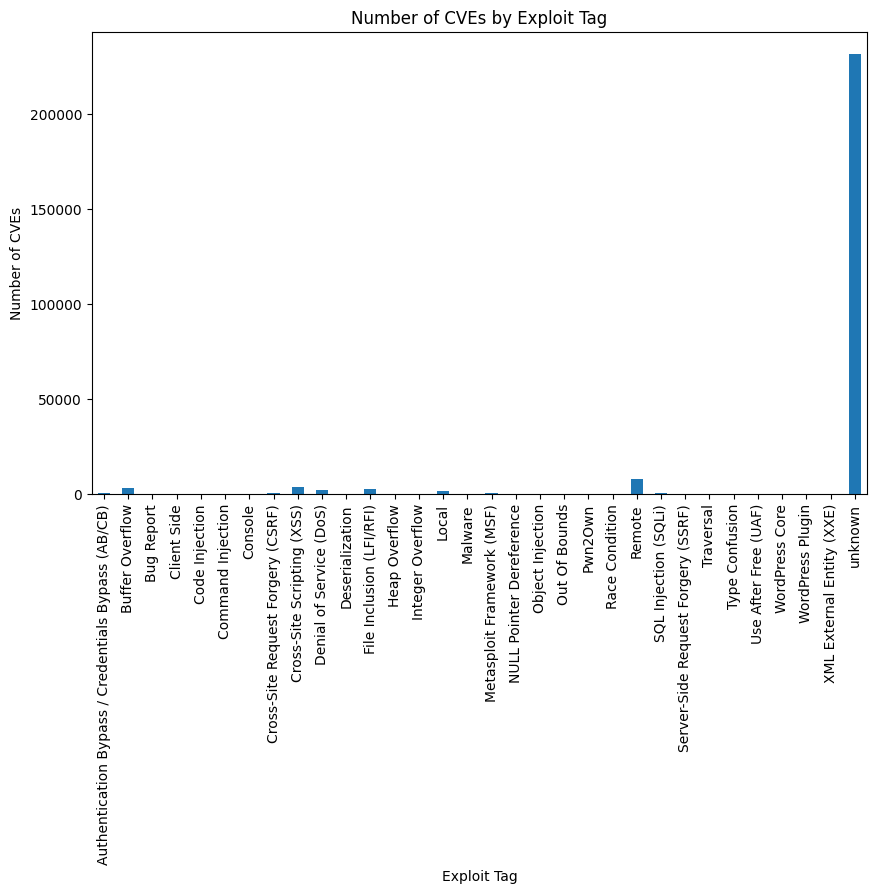

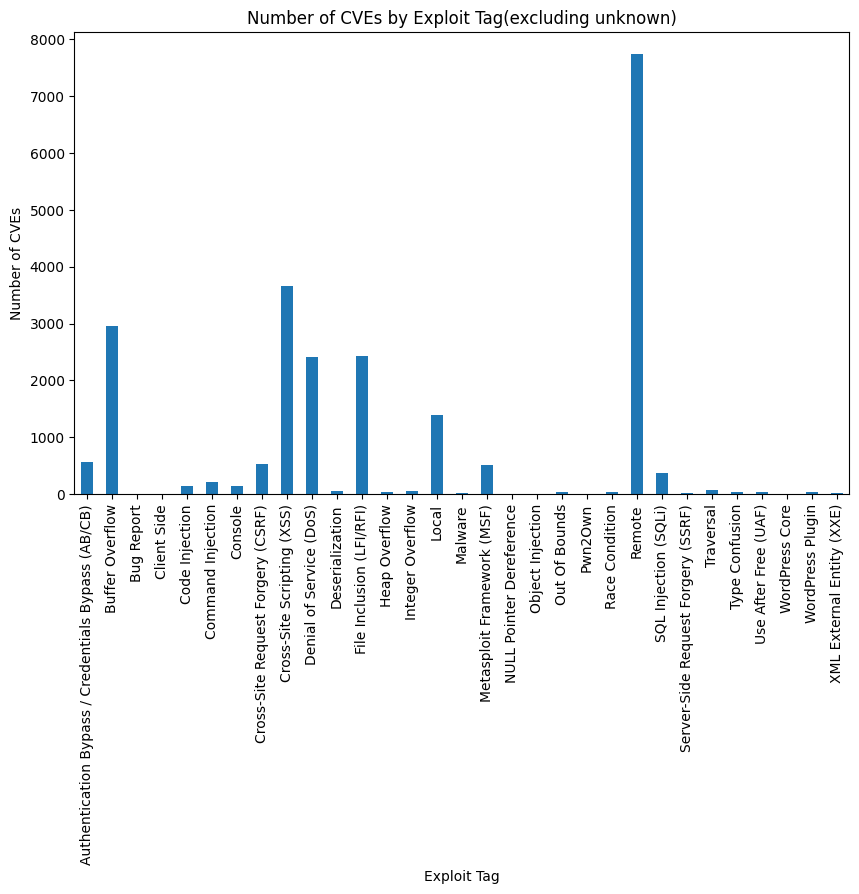

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

from main import CVES_WITH_EXPLOIT_TAG_COLLECTION
from src.infrastructure.mongodb_cve_repository import MongoDBCVERepository

cves_with_exploit_tag_repository = MongoDBCVERepository(collection_name=CVES_WITH_EXPLOIT_TAG_COLLECTION)
cves = cves_with_exploit_tag_repository.find_all()
df = pd.DataFrame(list(cves))

exploit_counts = df.groupby('exploit_tag_generated').size()

plt.figure(figsize=(10, 6))
exploit_counts.plot(kind='bar')
plt.xlabel('Exploit Tag')
plt.ylabel('Number of CVEs')
plt.title('Number of CVEs by Exploit Tag')
plt.show()

df_filtered = df[(~df['exploit_tag_generated'].isna()) & (df['exploit_tag_generated'] != "") & (df['exploit_tag_generated'] != "unknown")]

exploit_counts_filtered = df_filtered.groupby('exploit_tag_generated').size()

plt.figure(figsize=(10, 6))
exploit_counts_filtered.plot(kind='bar')
plt.xlabel('Exploit Tag')
plt.ylabel('Number of CVEs')
plt.title('Number of CVEs by Exploit Tag(excluding unknown)')
plt.show()

### Third iteration: Exploit Tag predicted with NLP

As a second iteration, CVEs with unknown Exploit Tag are predicted with a NLP model.

This is the result:

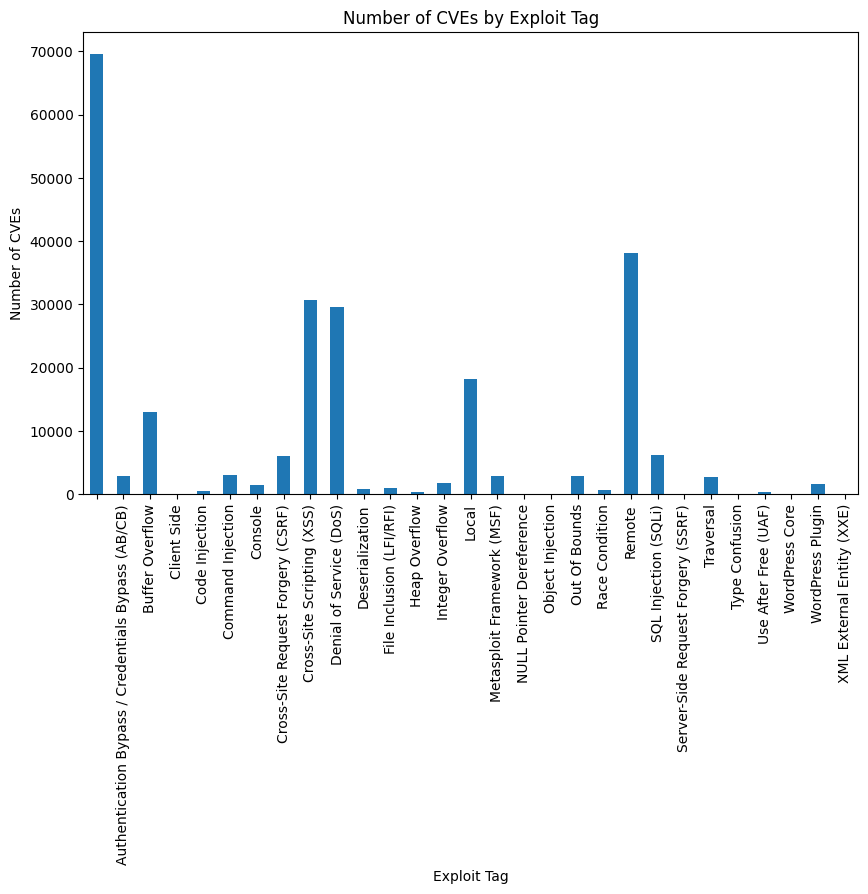

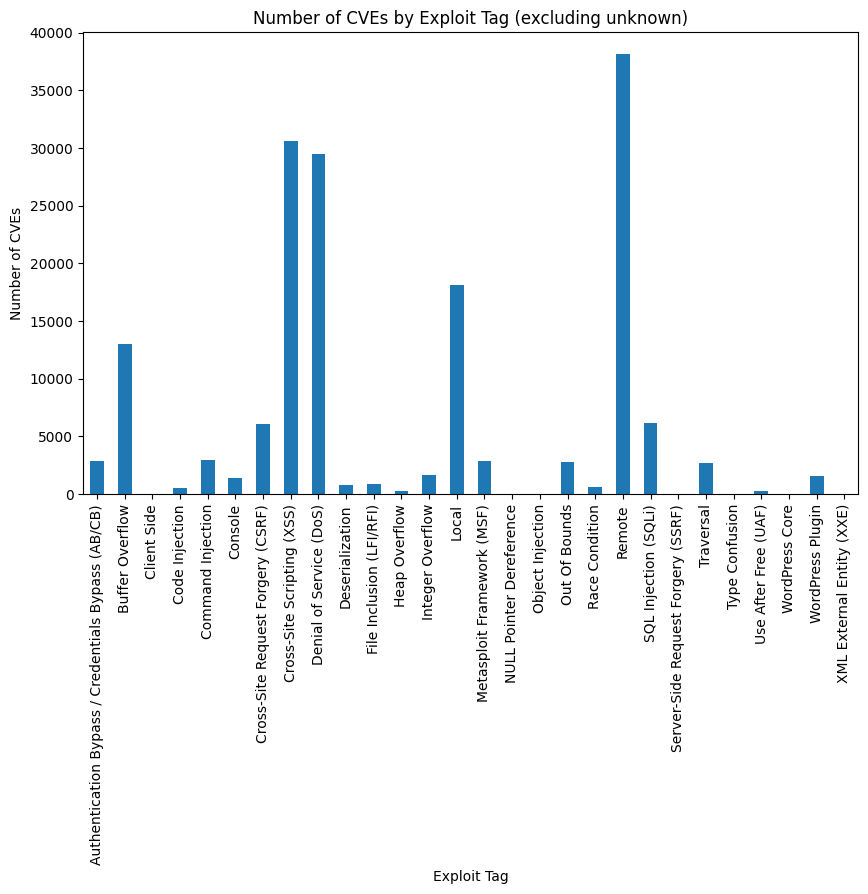

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from main import CVES_WITH_PREDICTED_EXPLOIT_TAG_COLLECTION
from src.infrastructure.mongodb_cve_repository import MongoDBCVERepository

cves_with_predicted_exploit_tag_repository = MongoDBCVERepository(collection_name=CVES_WITH_PREDICTED_EXPLOIT_TAG_COLLECTION)
cves = cves_with_predicted_exploit_tag_repository.find_all()
df = pd.DataFrame(list(cves))

df.loc[df['predicted_exploit_tag_confidence'] < MINIMUM_CONFIDENCE_THRESHOLD, 'predicted_exploit_tag'] = ''

df["exploit_tag_final"] = np.where(
    ((df["exploit_tag_x"].isna()) | (df["exploit_tag_x"] == "") | (df["exploit_tag_x"] == "unknown")),
    df["predicted_exploit_tag"],
    df["exploit_tag_x"],
)

exploit_counts = df.groupby('exploit_tag_final').size()

plt.figure(figsize=(10, 6))
exploit_counts.plot(kind='bar')
plt.xlabel('Exploit Tag')
plt.ylabel('Number of CVEs')
plt.title('Number of CVEs by Exploit Tag')
plt.show()

df_filtered = df[(df['exploit_tag_final'] != '') & (df['exploit_tag_final'] != 'unknown')]
exploit_counts_filtered = df_filtered.groupby('exploit_tag_final').size()

plt.figure(figsize=(10, 6))
exploit_counts_filtered.plot(kind='bar')
plt.xlabel('Exploit Tag')
plt.ylabel('Number of CVEs')
plt.title('Number of CVEs by Exploit Tag (excluding unknown)')
plt.show()

## CVEs by Exploit Tag over time

Now you can see how CVEs where created by Exploit Tag over time:

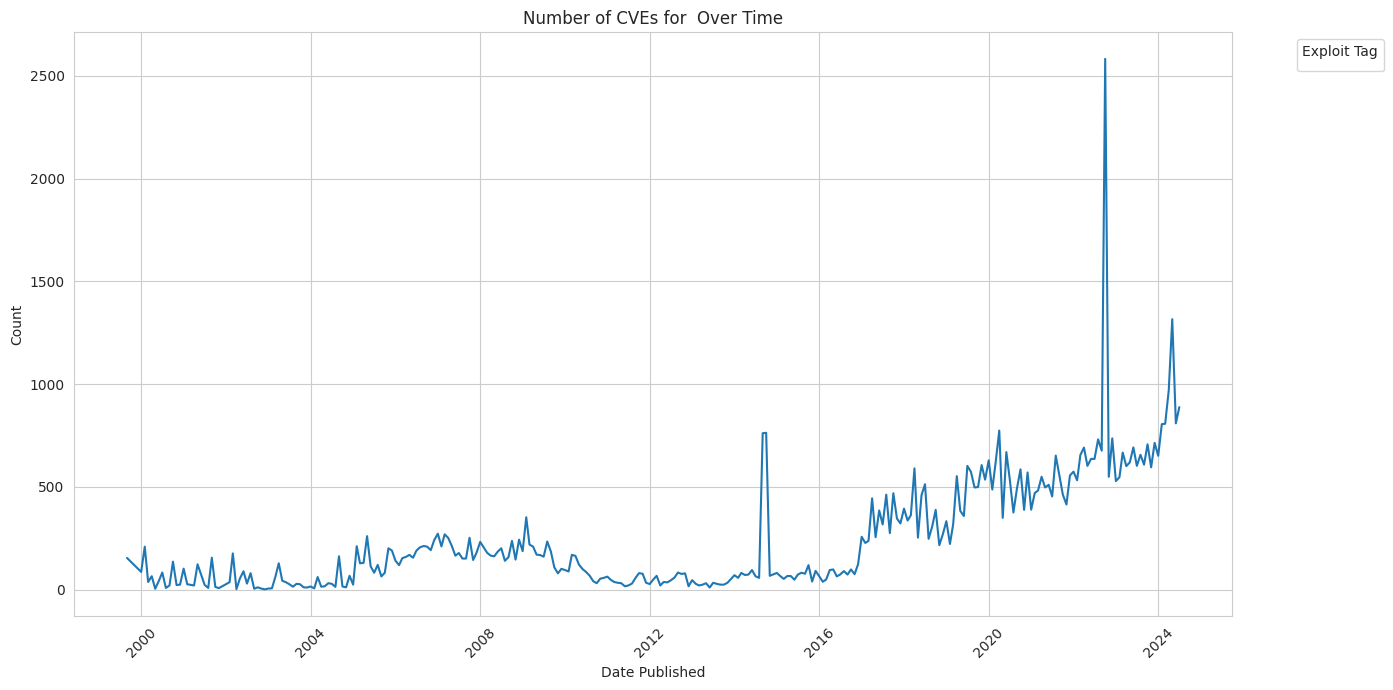

<Figure size 640x480 with 0 Axes>

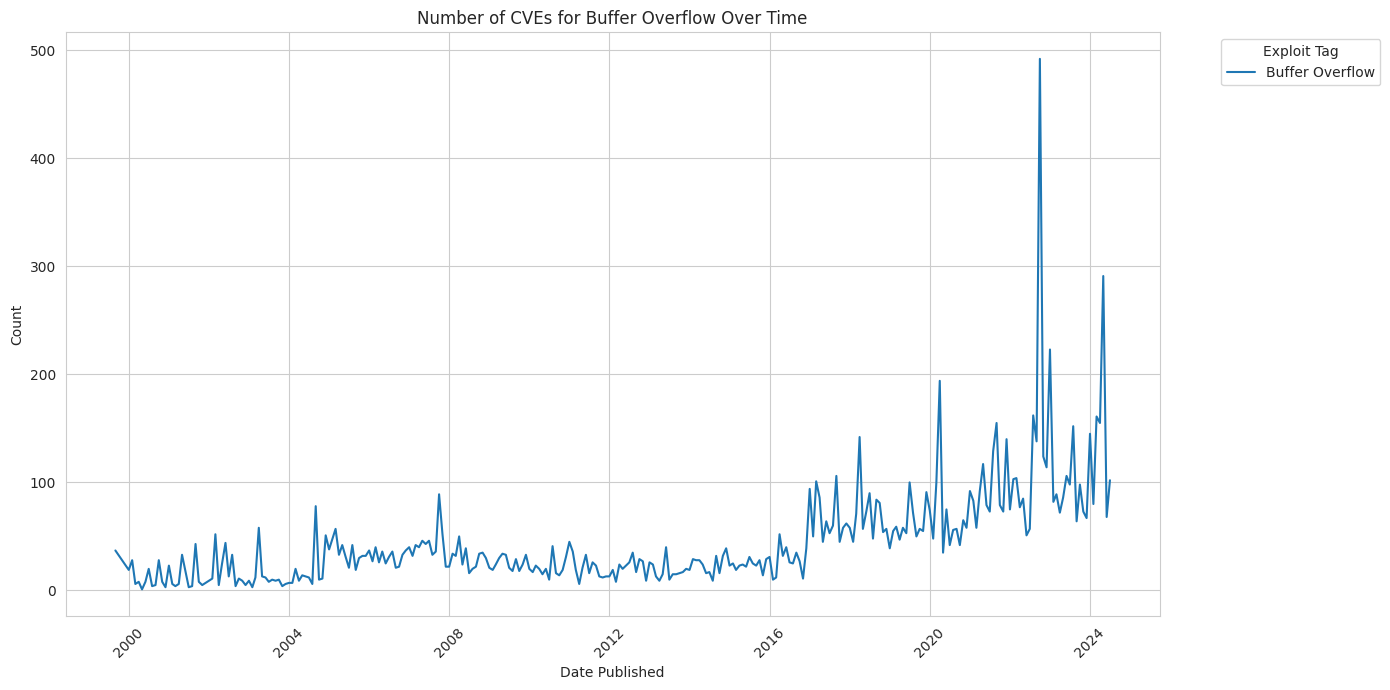

<Figure size 640x480 with 0 Axes>

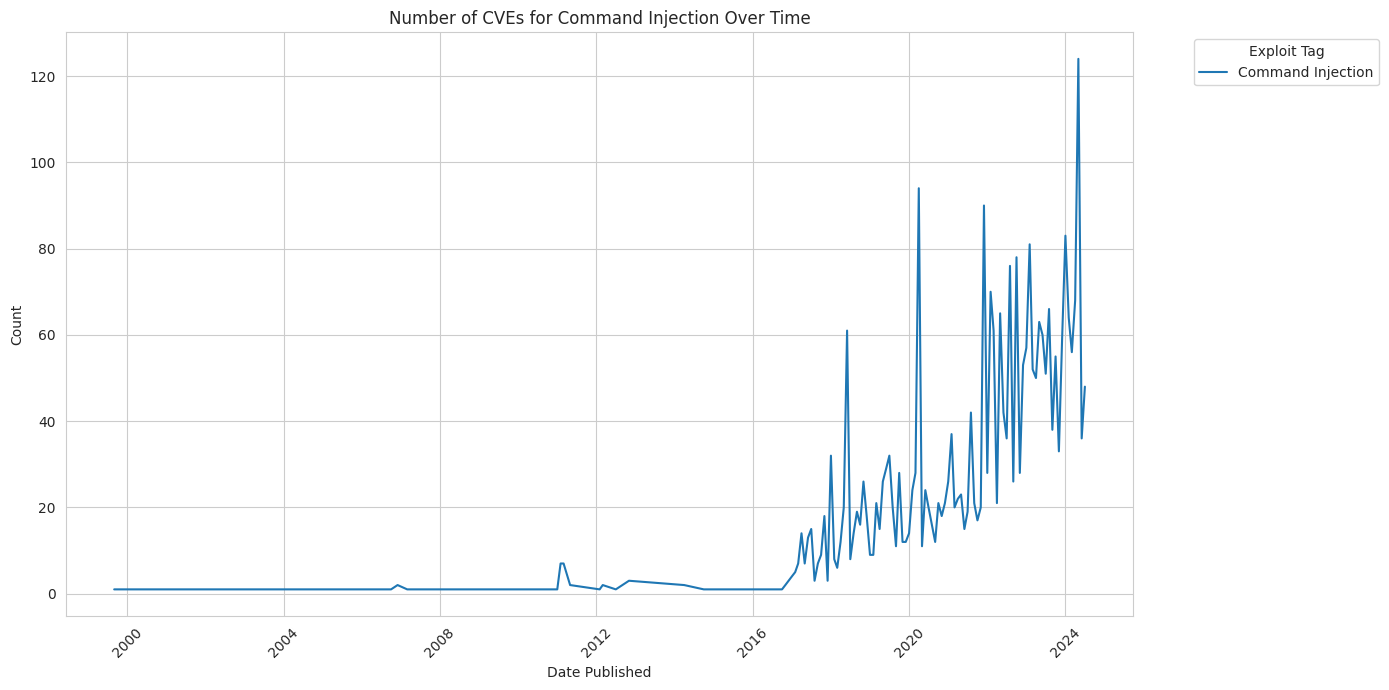

<Figure size 640x480 with 0 Axes>

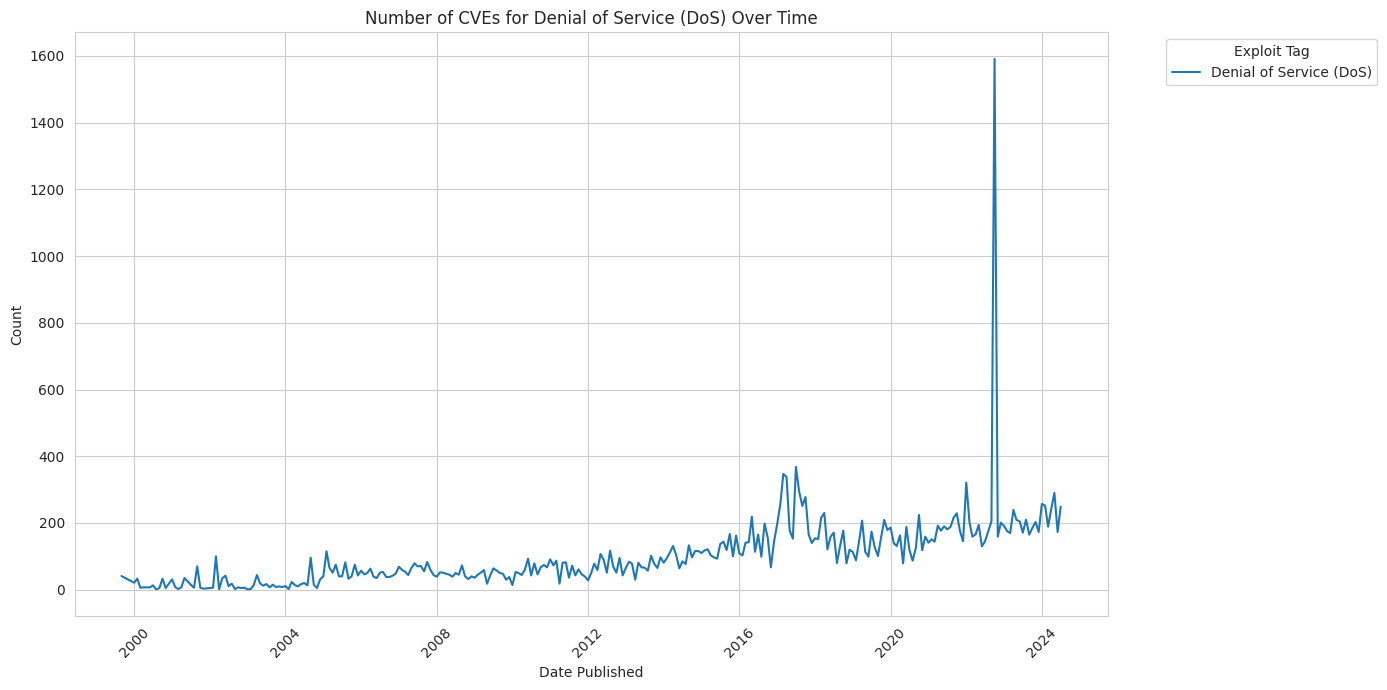

<Figure size 640x480 with 0 Axes>

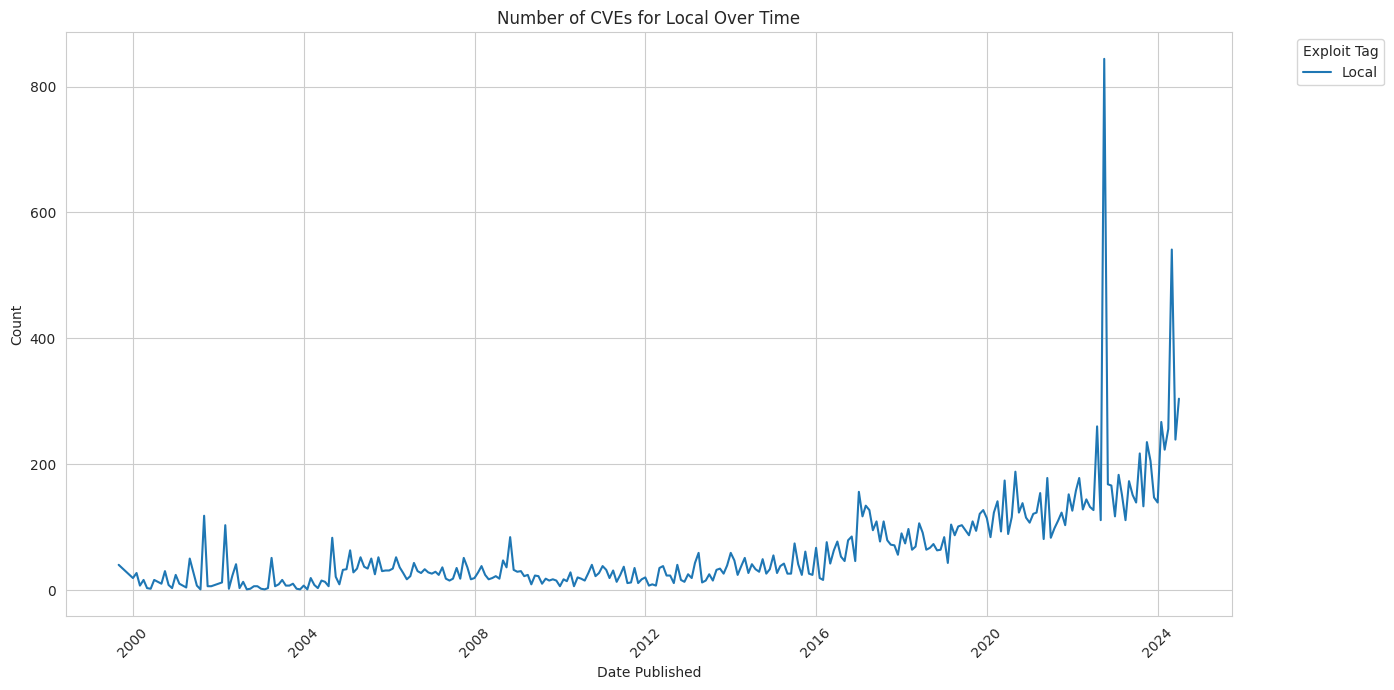

<Figure size 640x480 with 0 Axes>

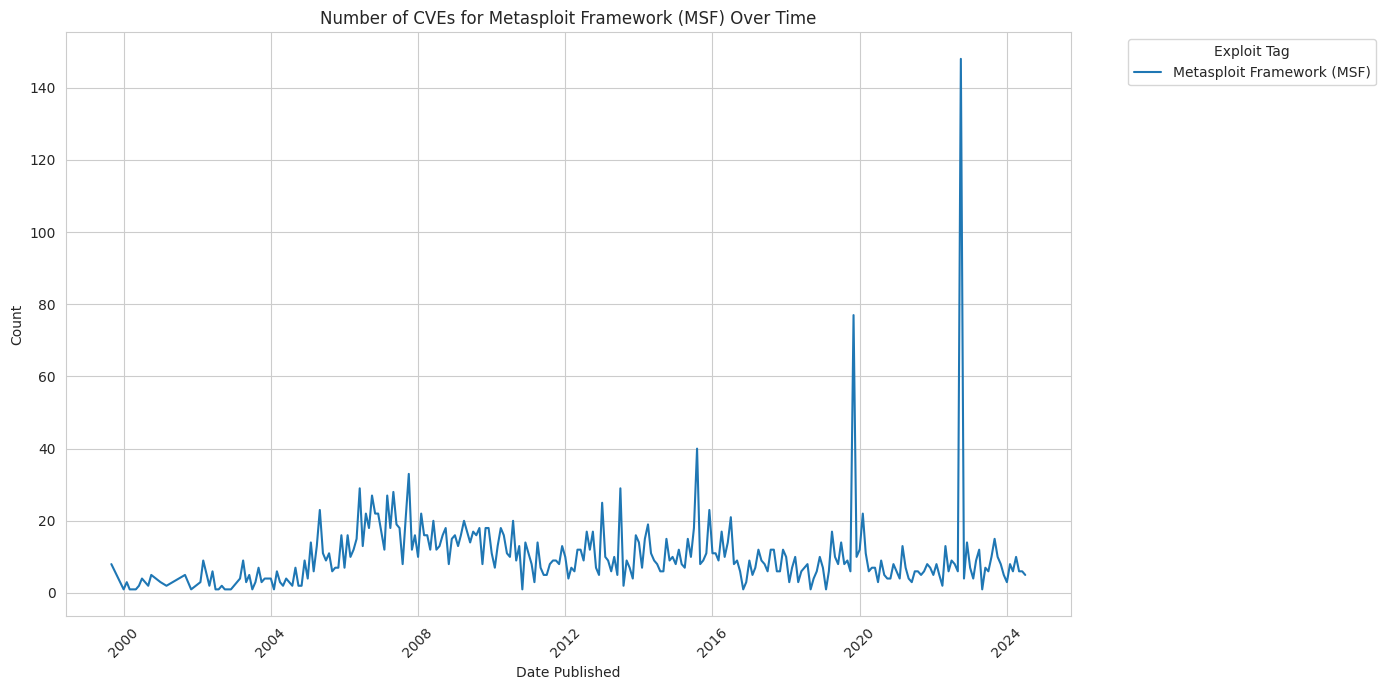

<Figure size 640x480 with 0 Axes>

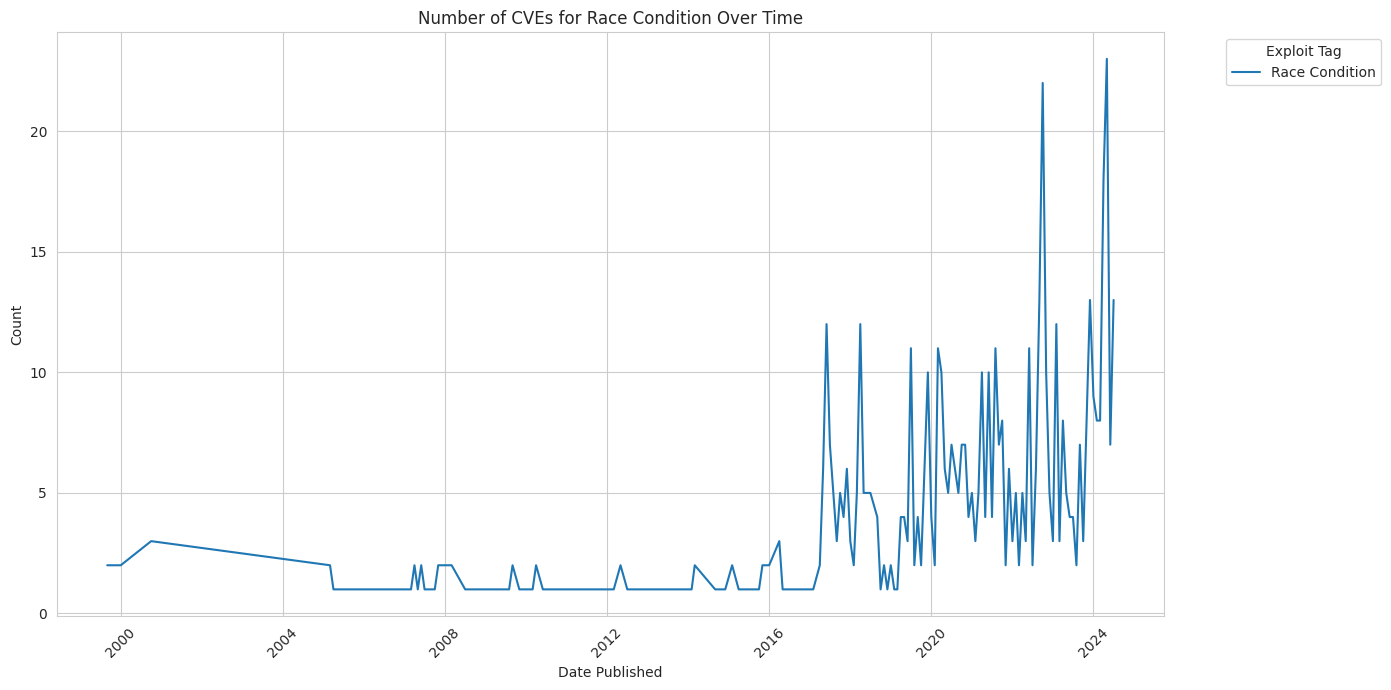

<Figure size 640x480 with 0 Axes>

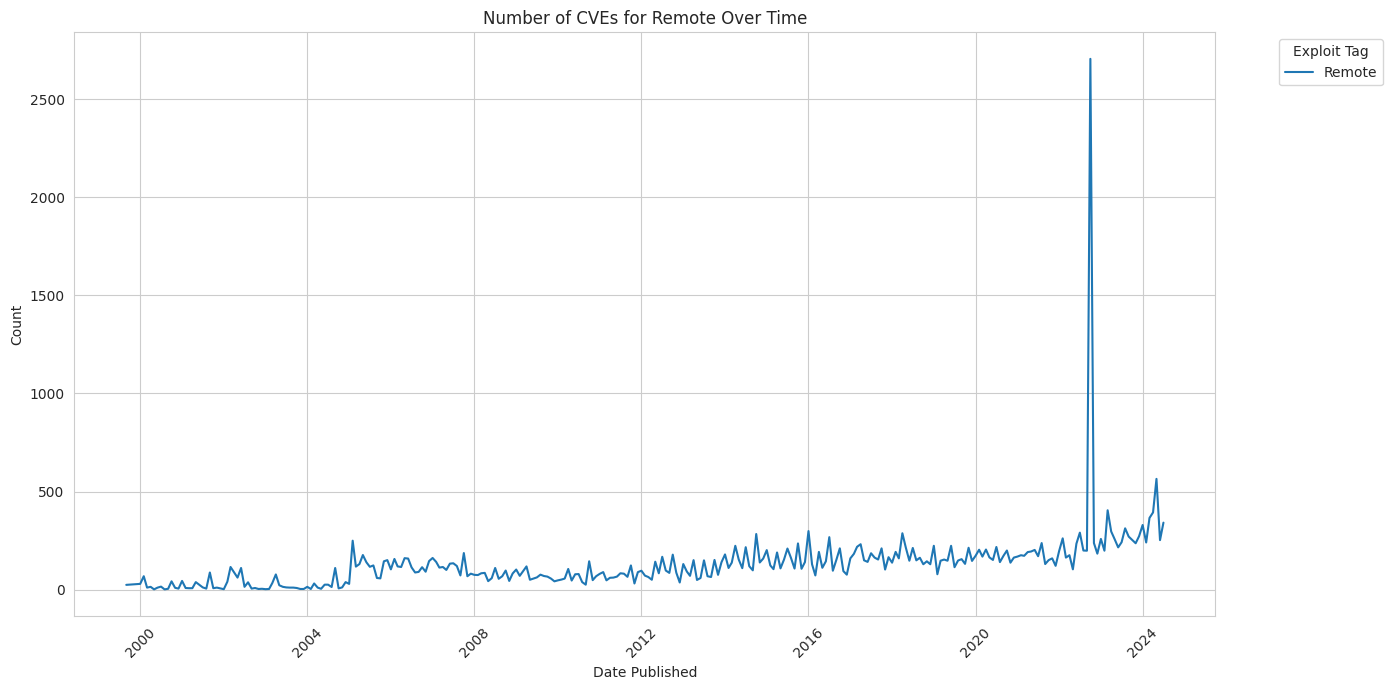

<Figure size 640x480 with 0 Axes>

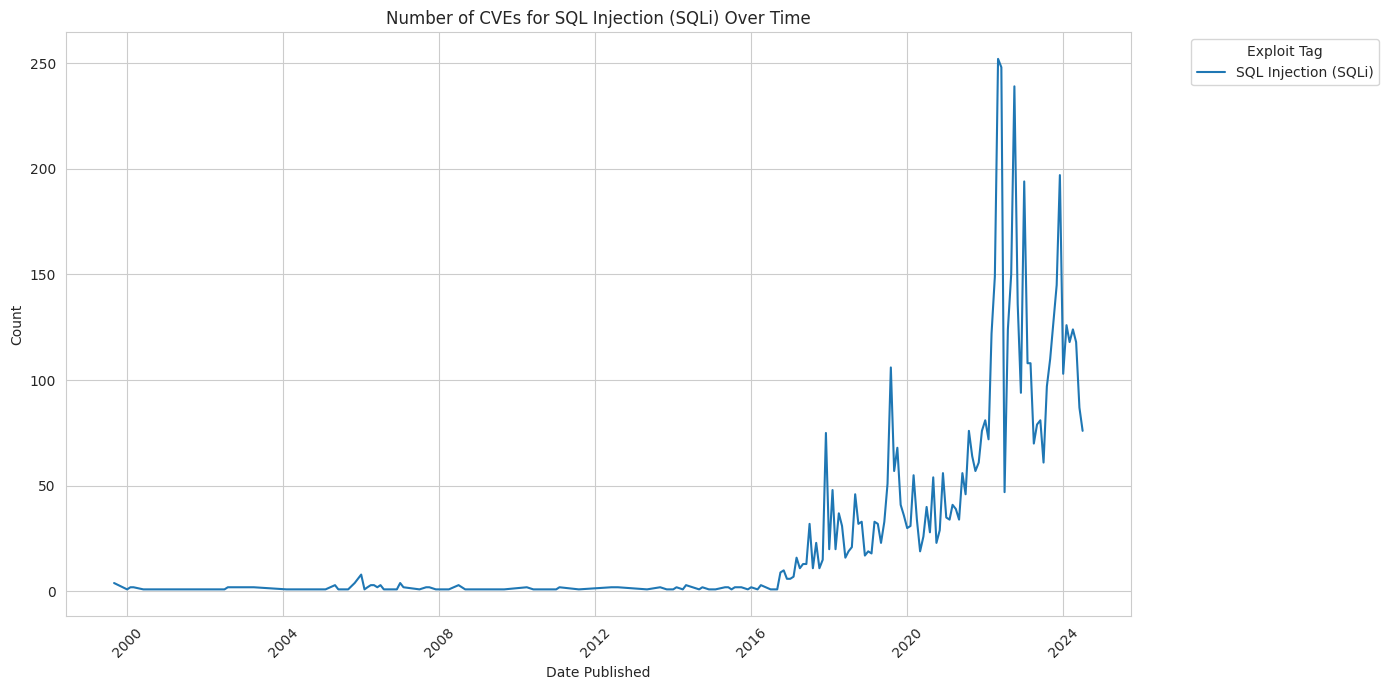

<Figure size 640x480 with 0 Axes>

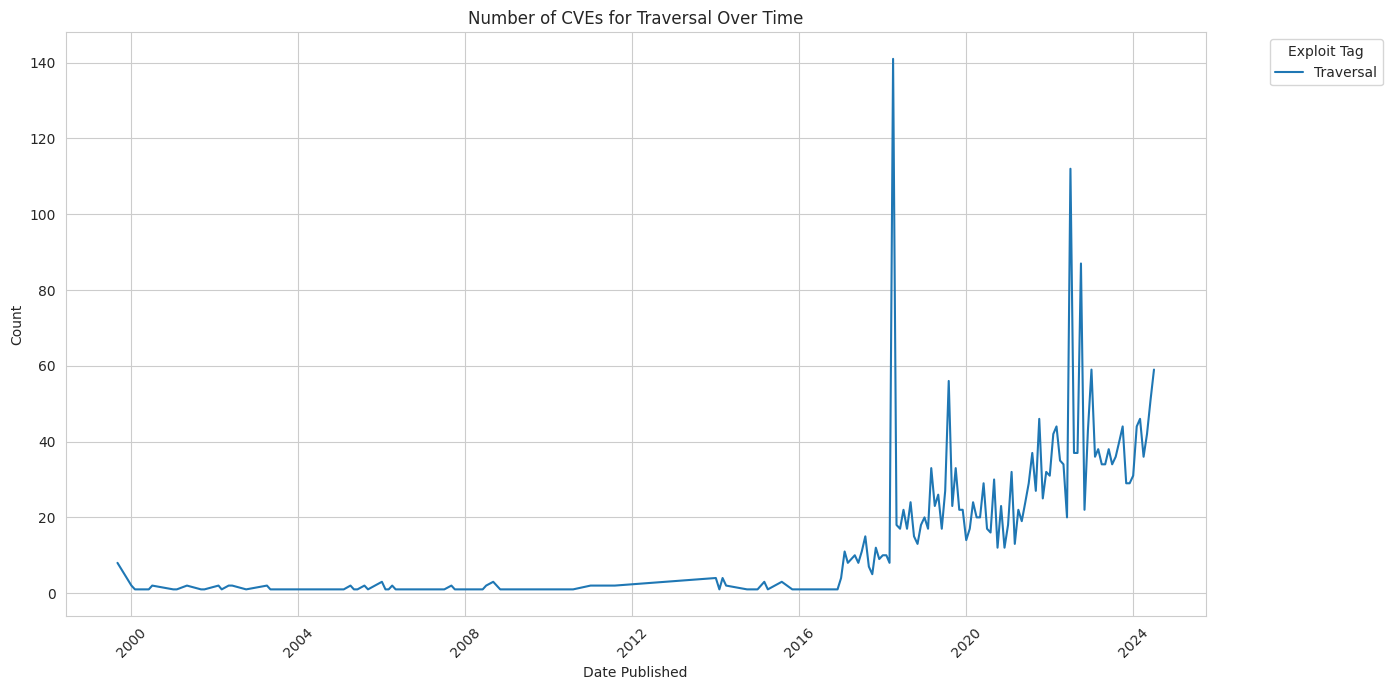

<Figure size 640x480 with 0 Axes>

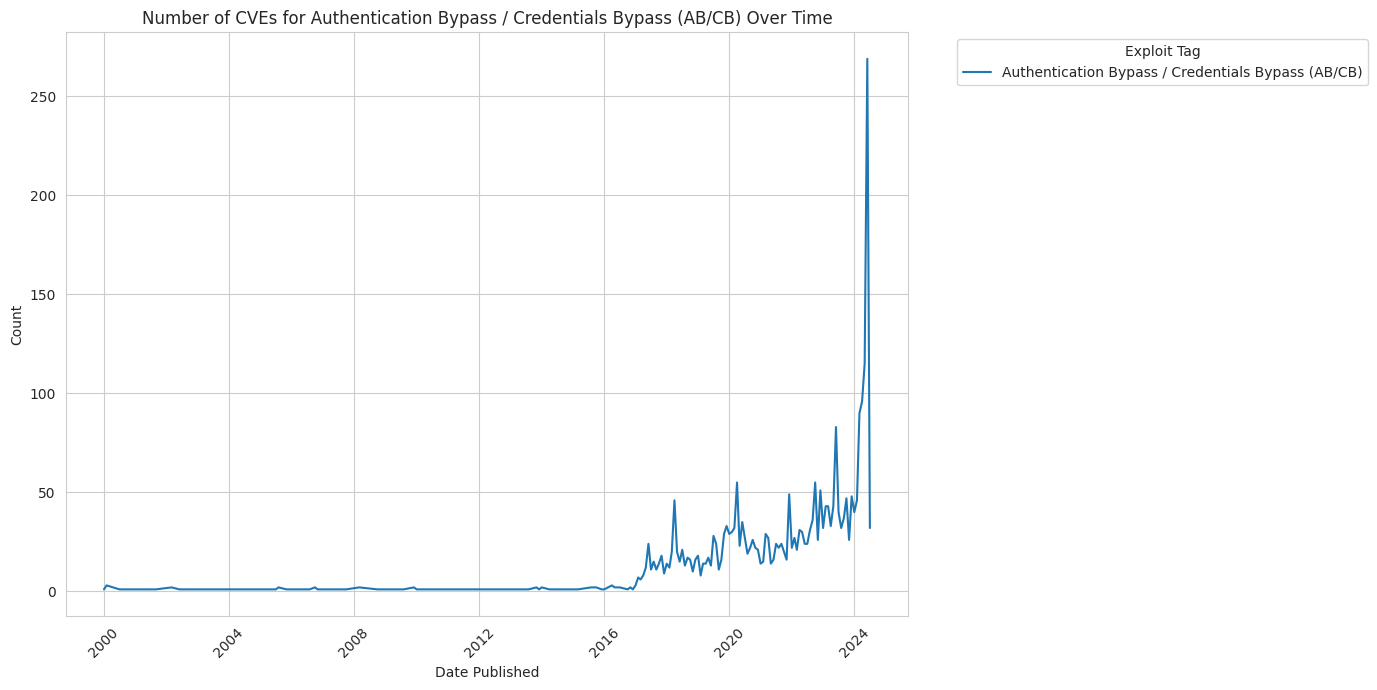

<Figure size 640x480 with 0 Axes>

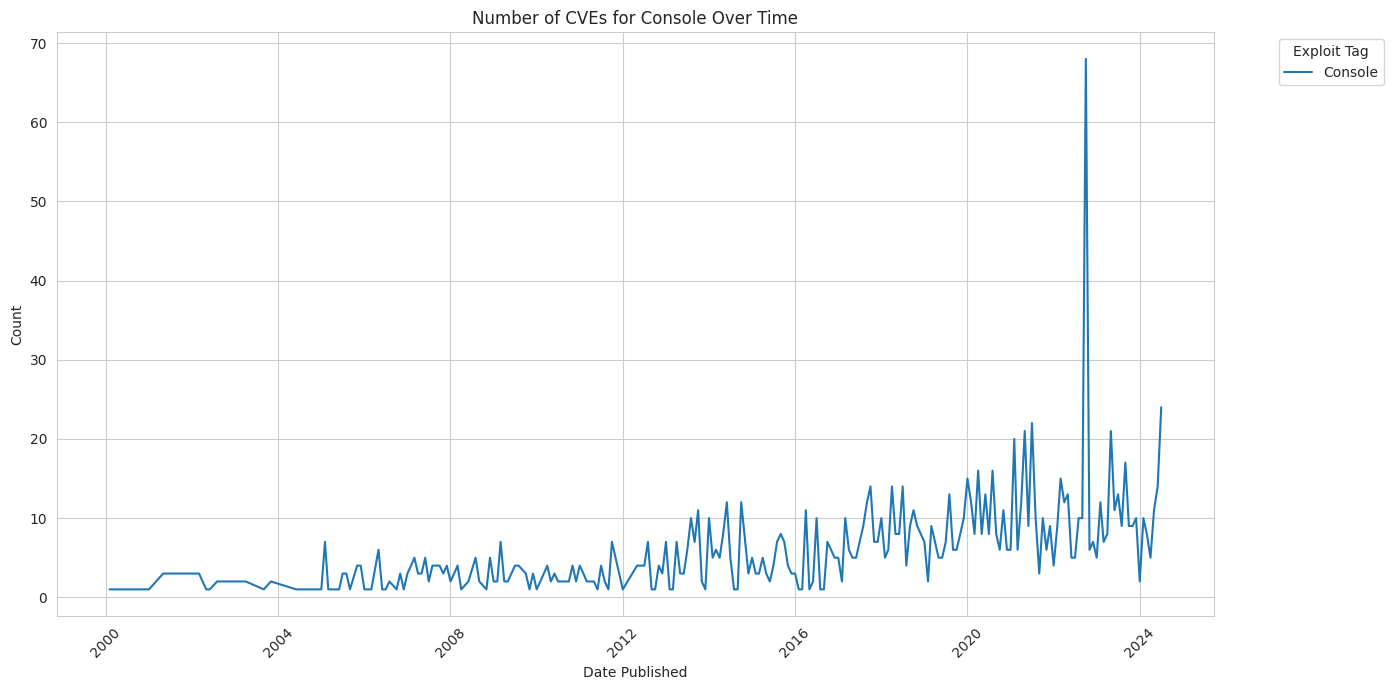

<Figure size 640x480 with 0 Axes>

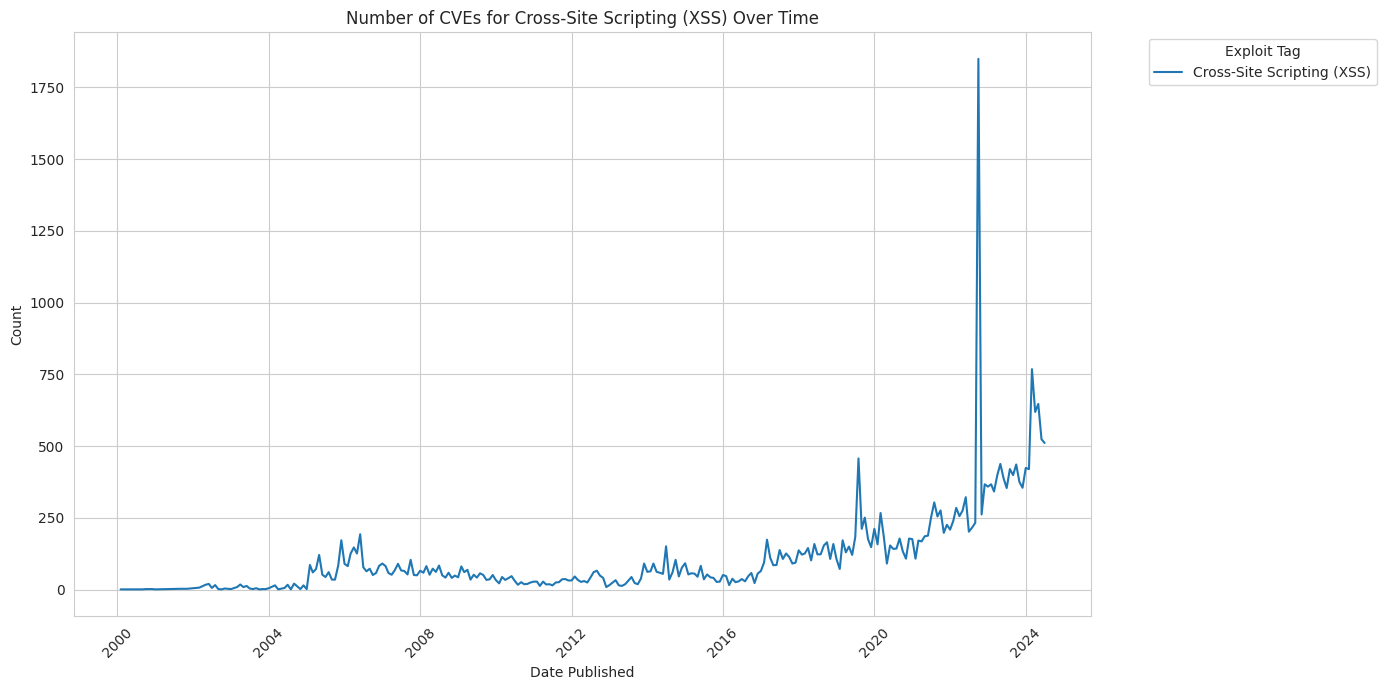

<Figure size 640x480 with 0 Axes>

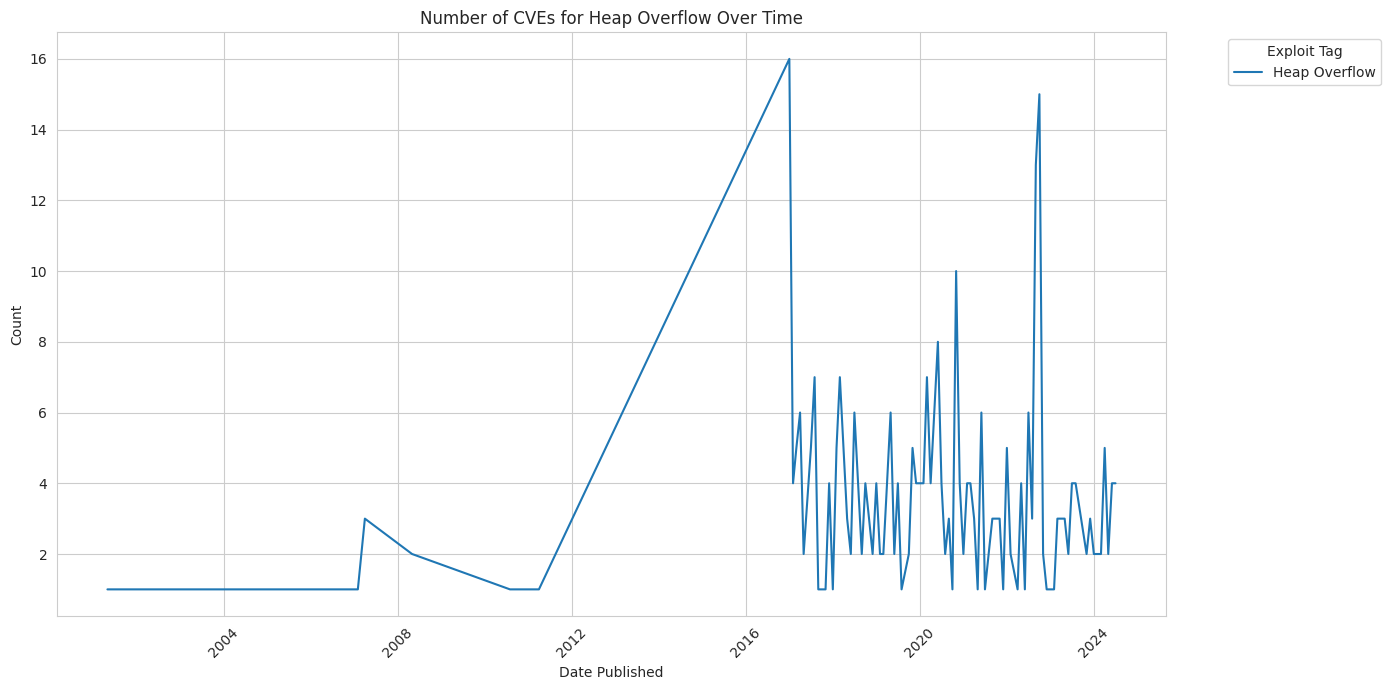

<Figure size 640x480 with 0 Axes>

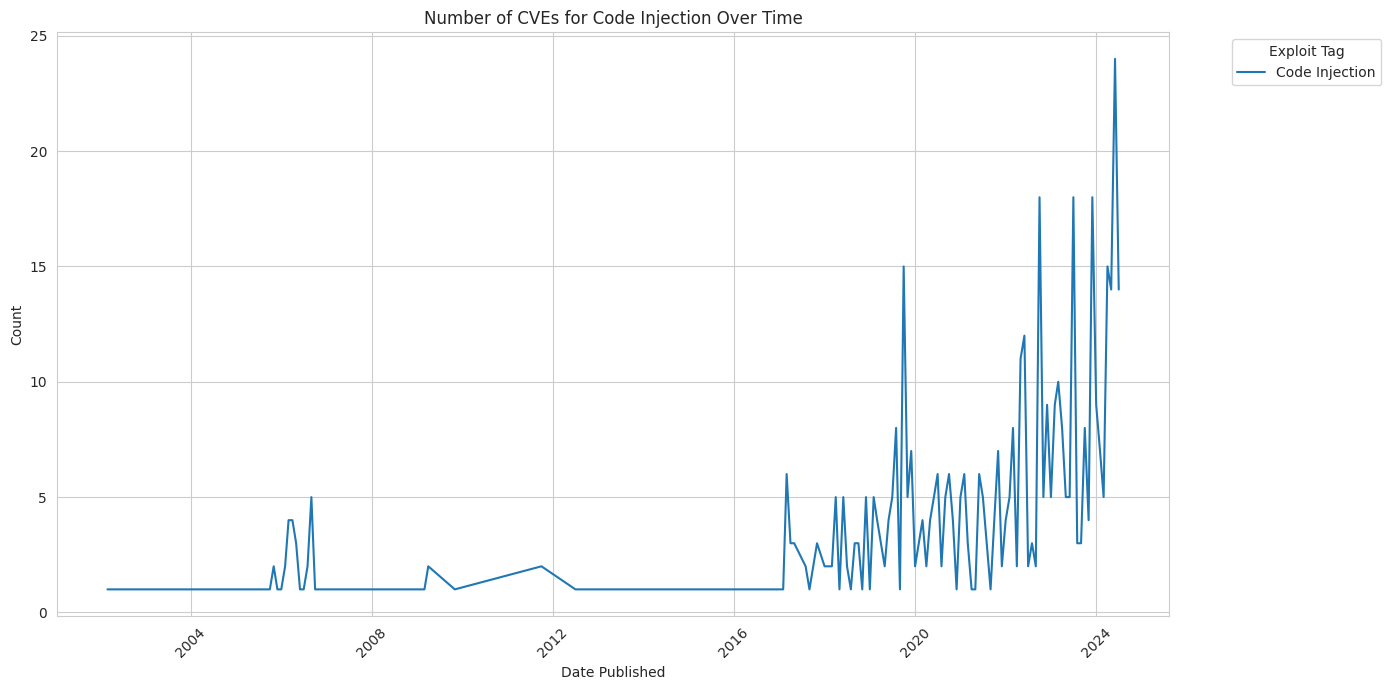

<Figure size 640x480 with 0 Axes>

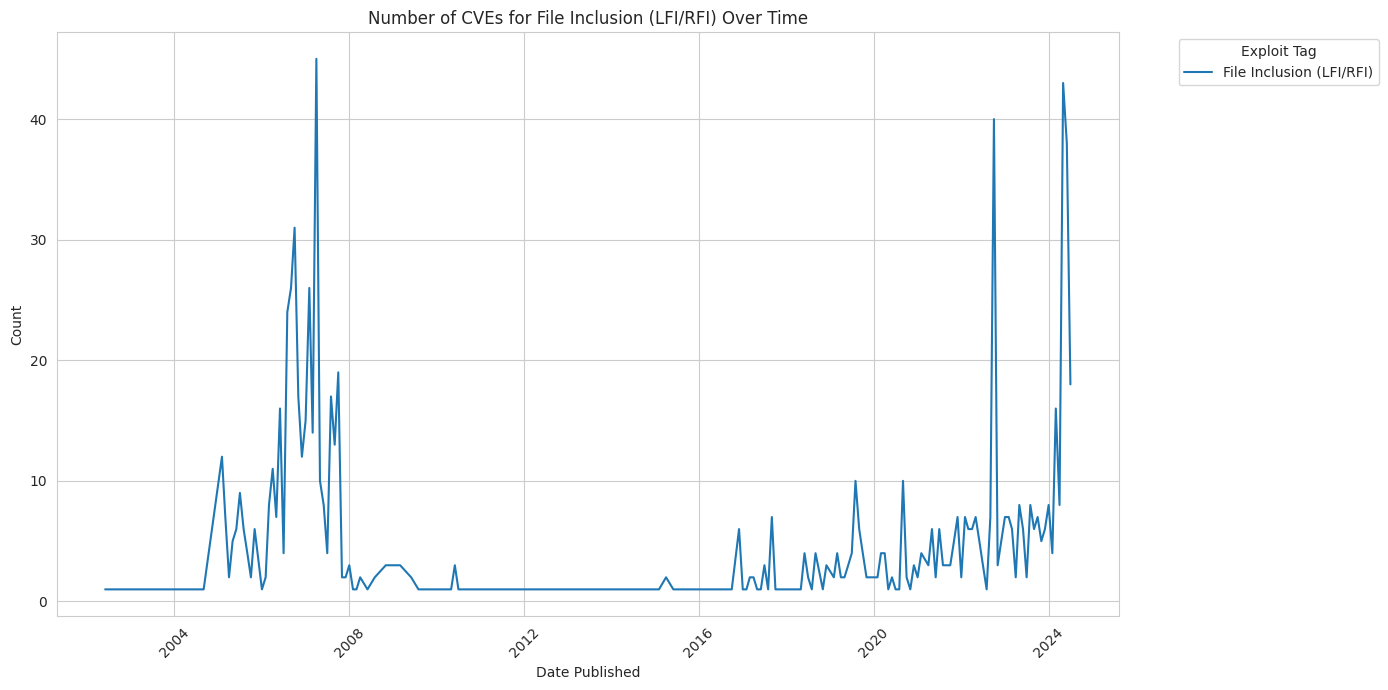

<Figure size 640x480 with 0 Axes>

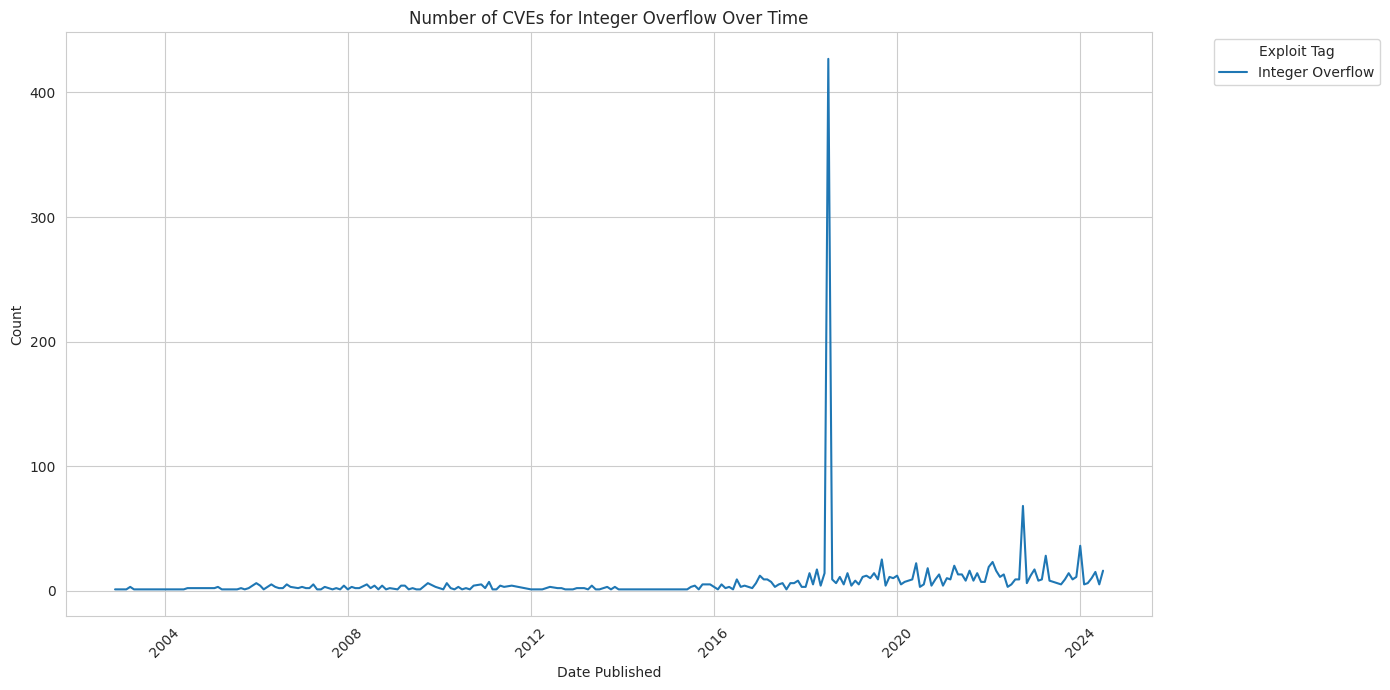

<Figure size 640x480 with 0 Axes>

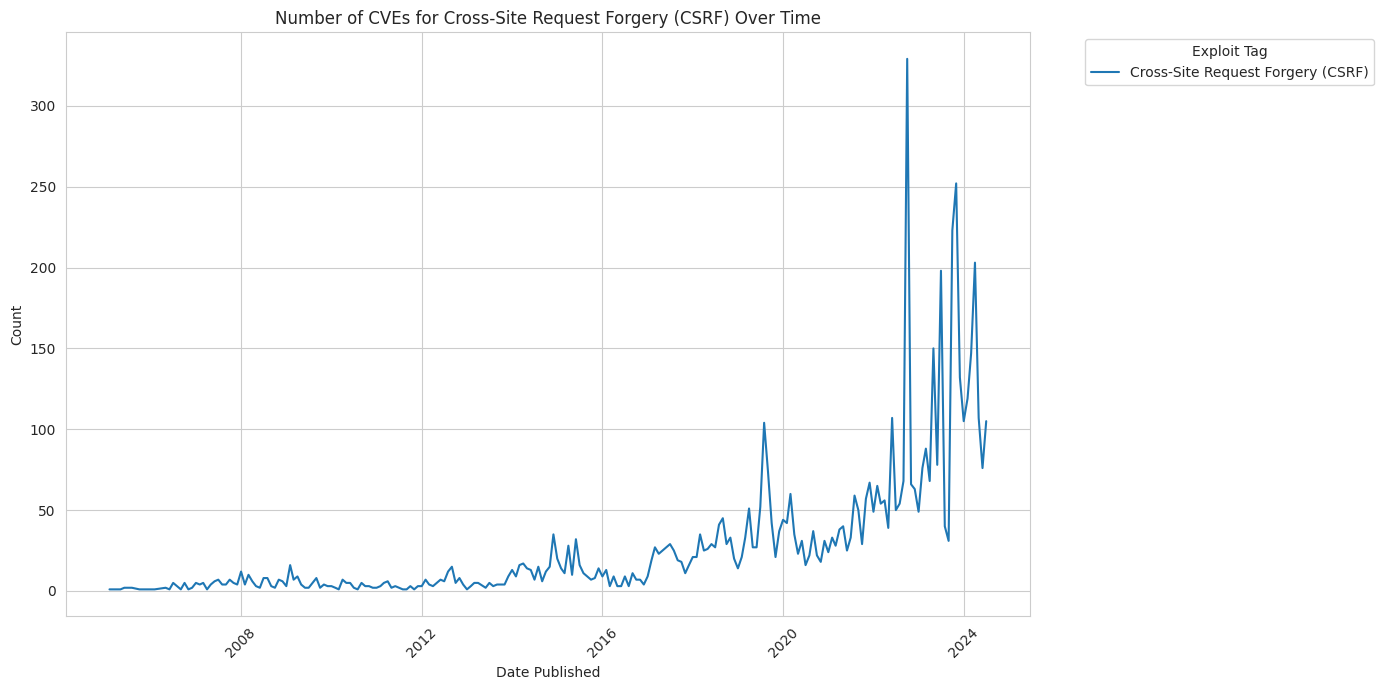

<Figure size 640x480 with 0 Axes>

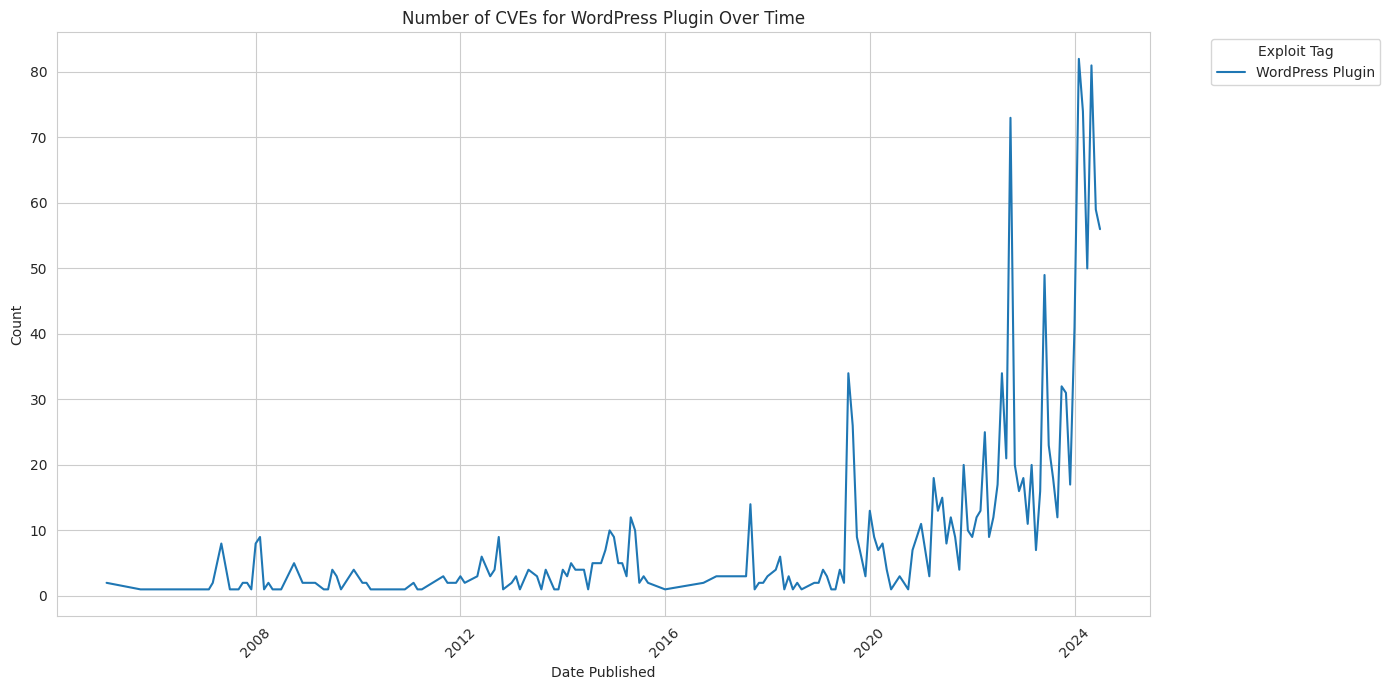

<Figure size 640x480 with 0 Axes>

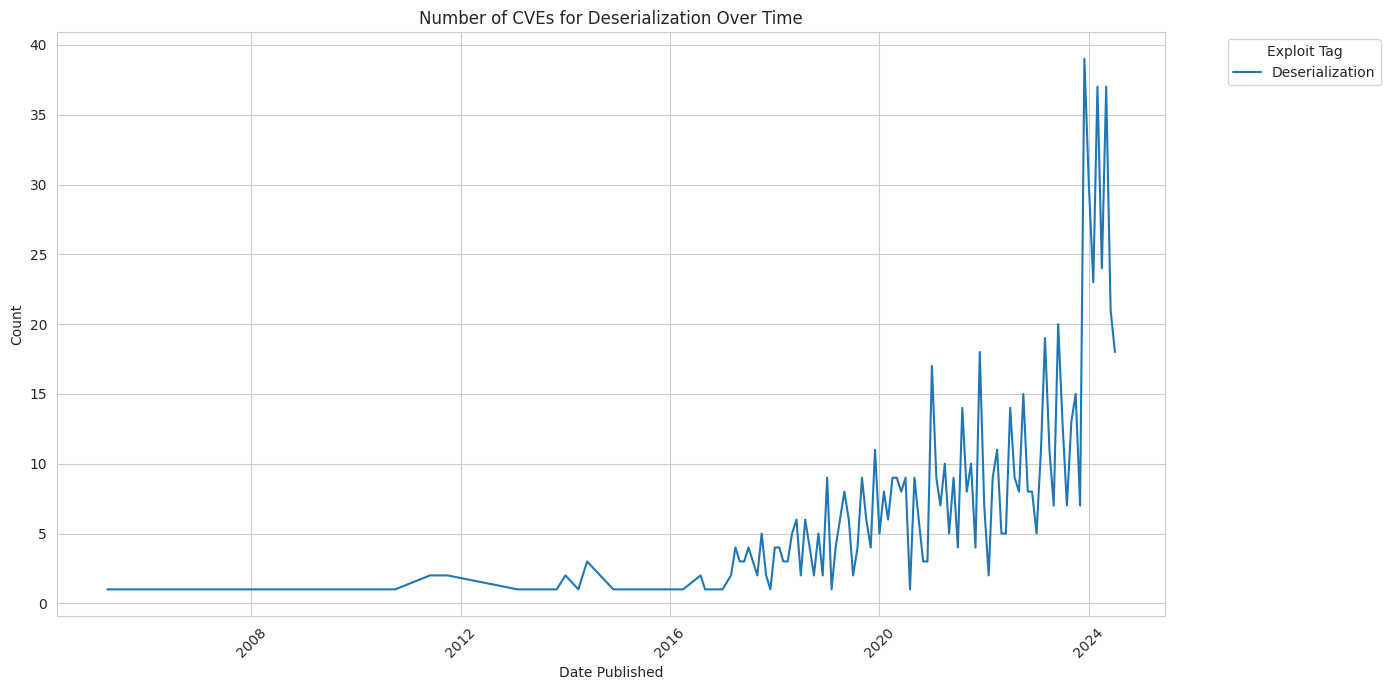

<Figure size 640x480 with 0 Axes>

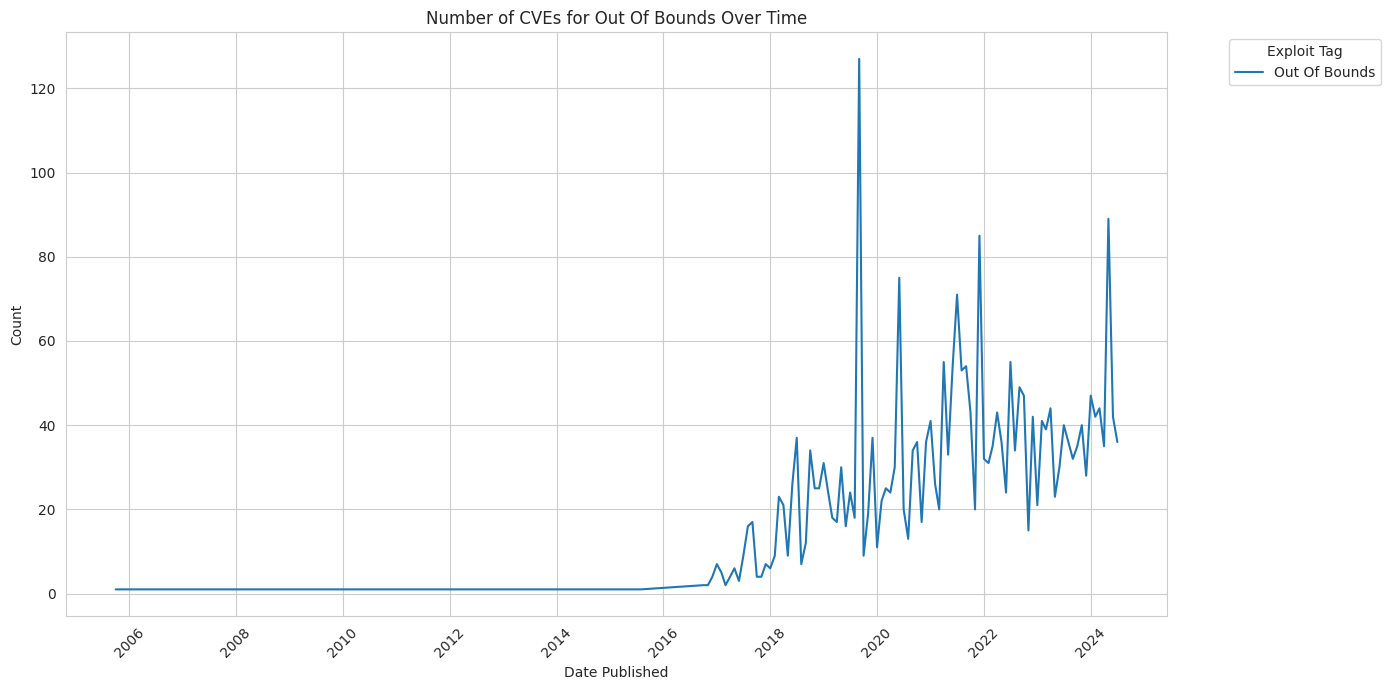

<Figure size 640x480 with 0 Axes>

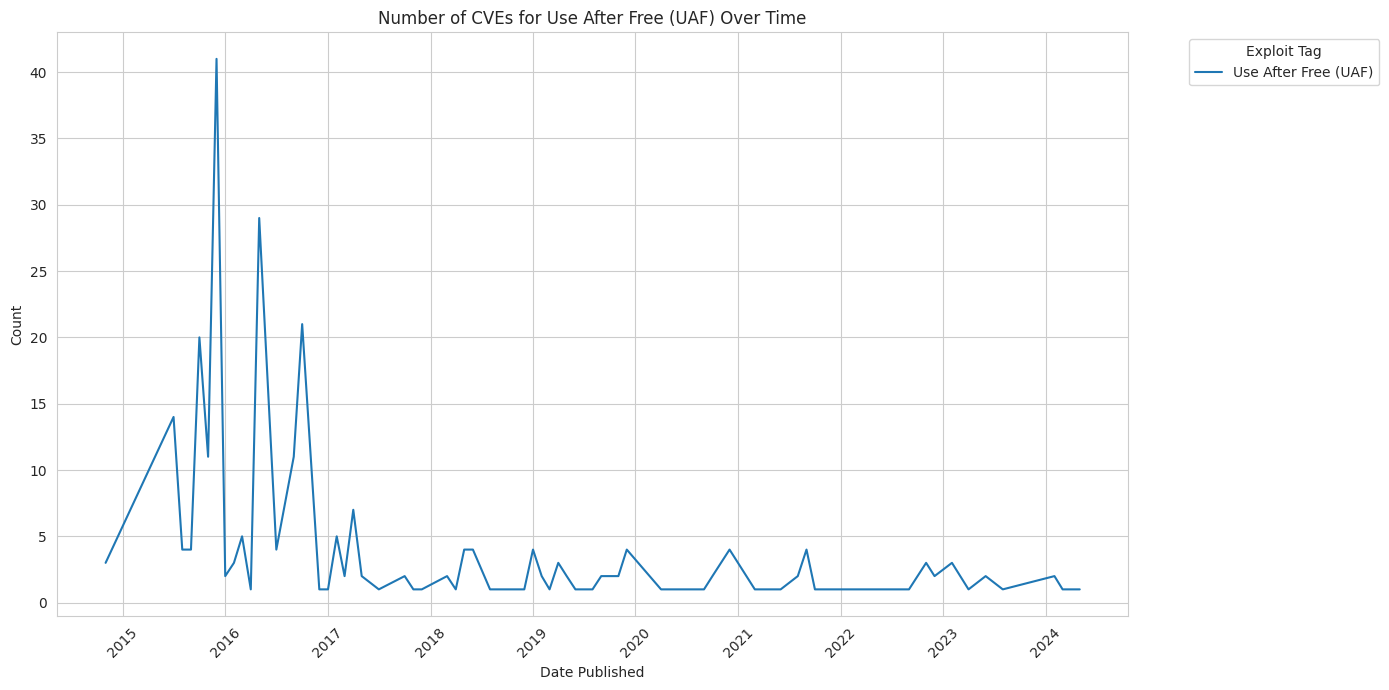

<Figure size 640x480 with 0 Axes>

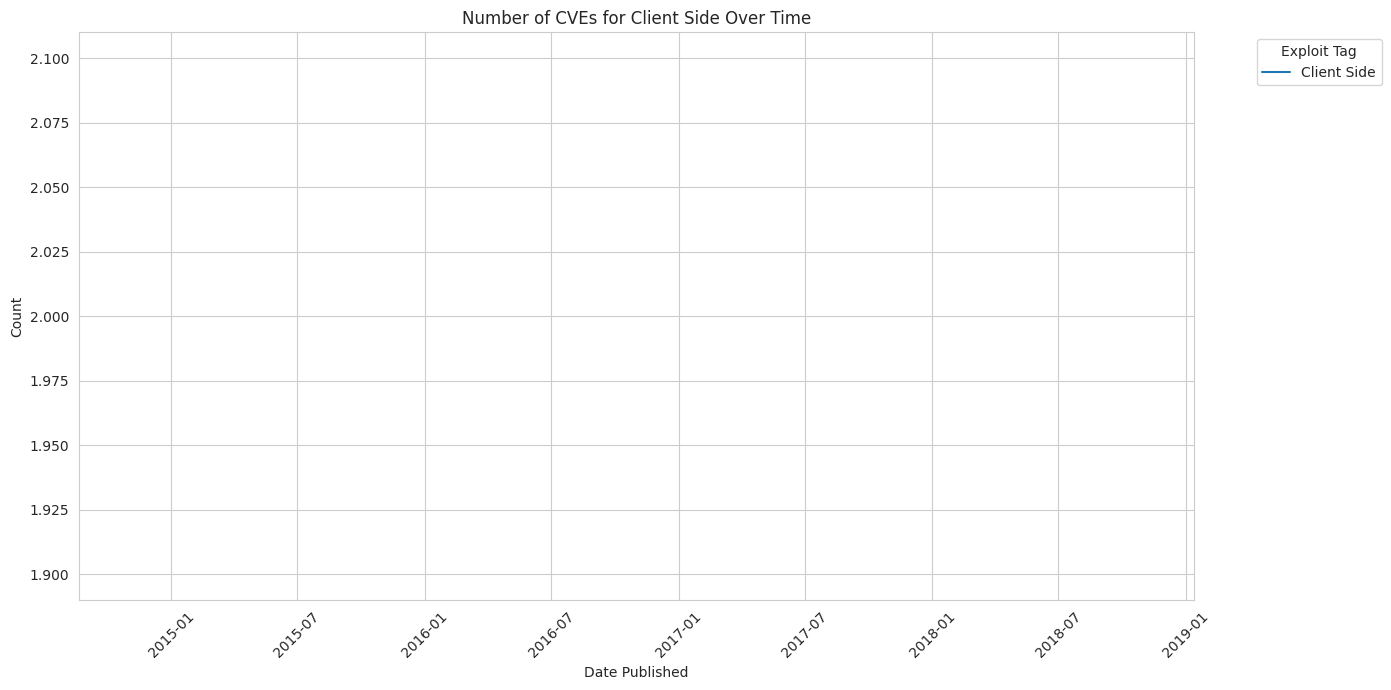

<Figure size 640x480 with 0 Axes>

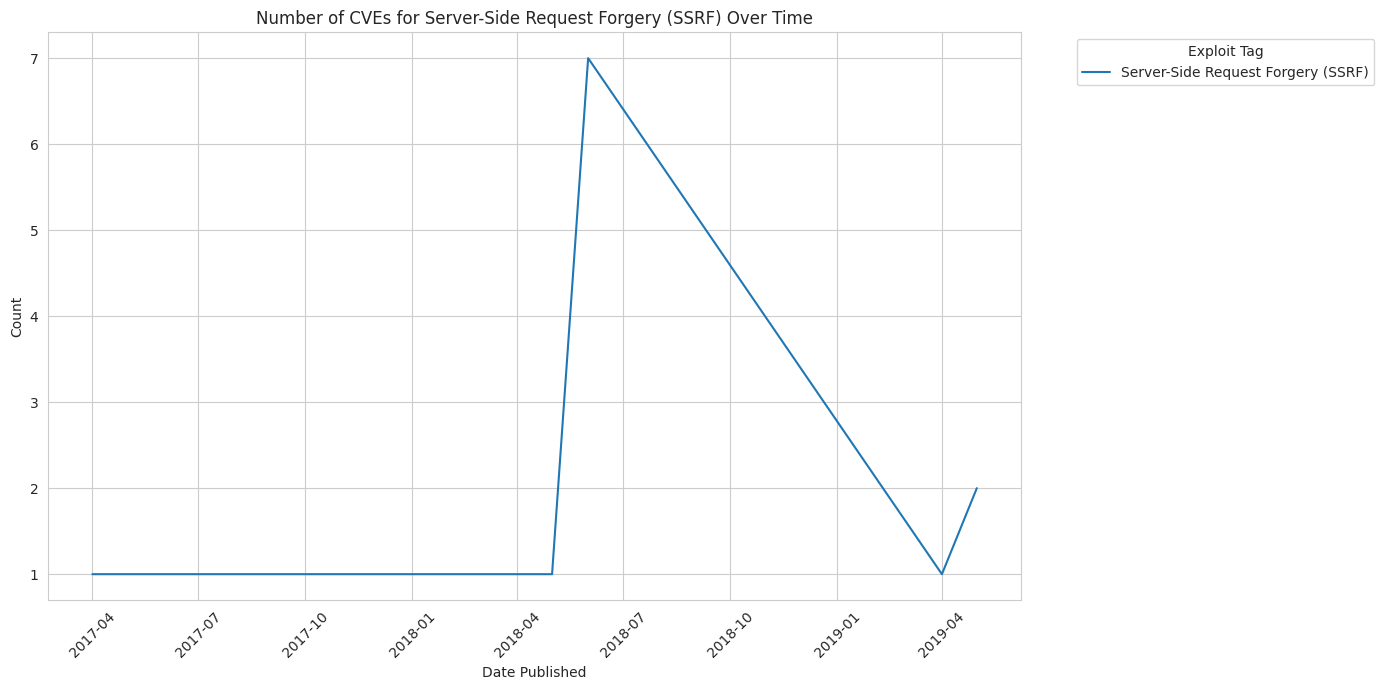

<Figure size 640x480 with 0 Axes>

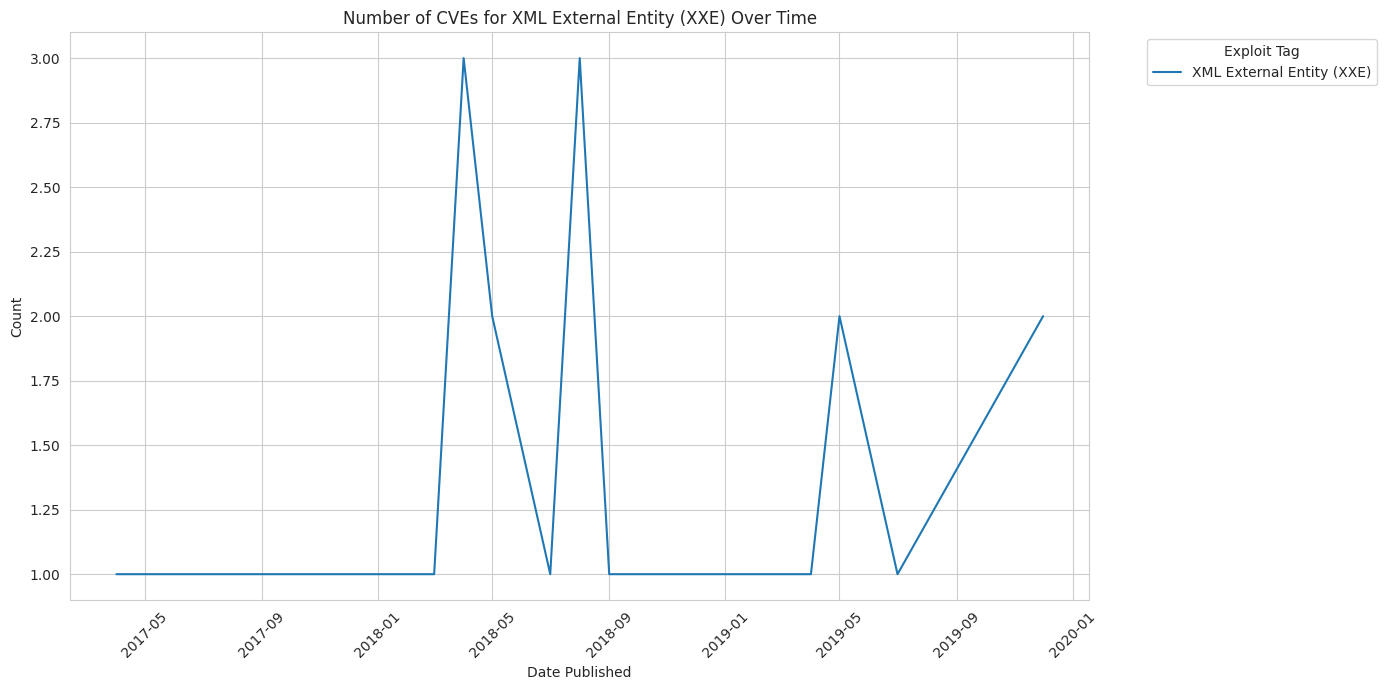

<Figure size 640x480 with 0 Axes>

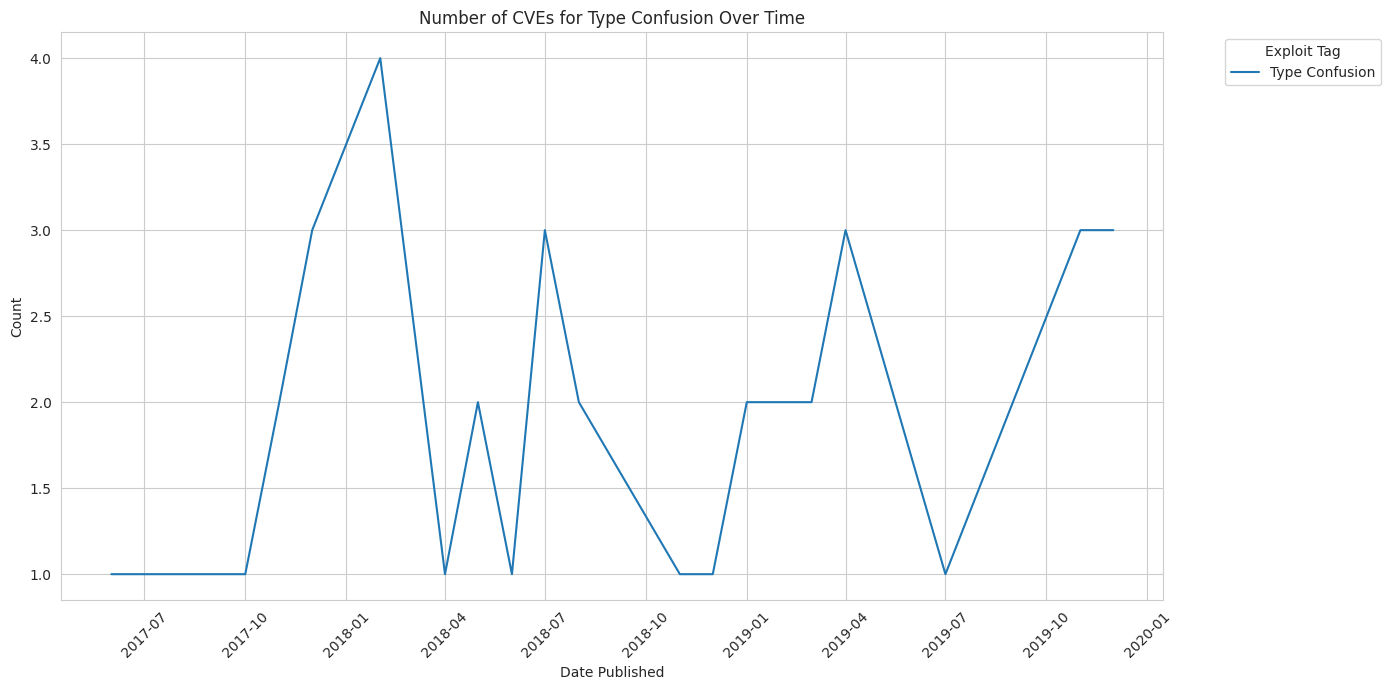

<Figure size 640x480 with 0 Axes>

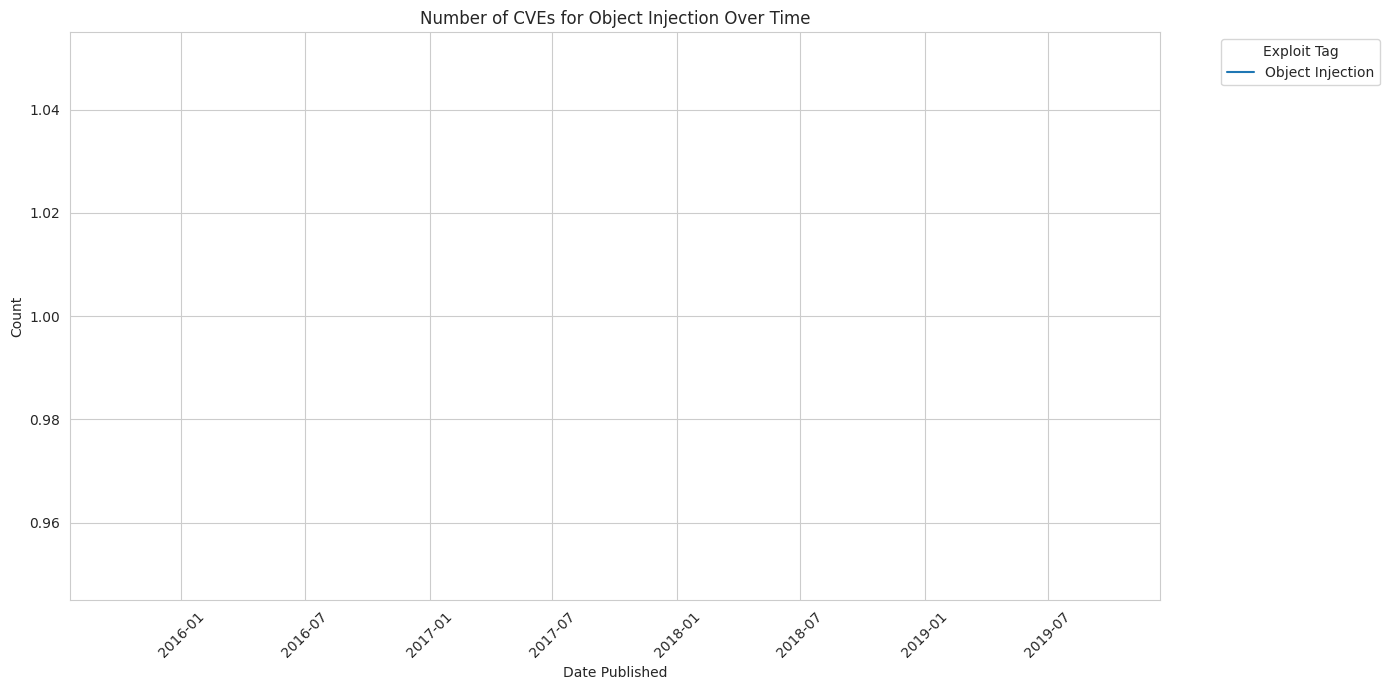

<Figure size 640x480 with 0 Axes>

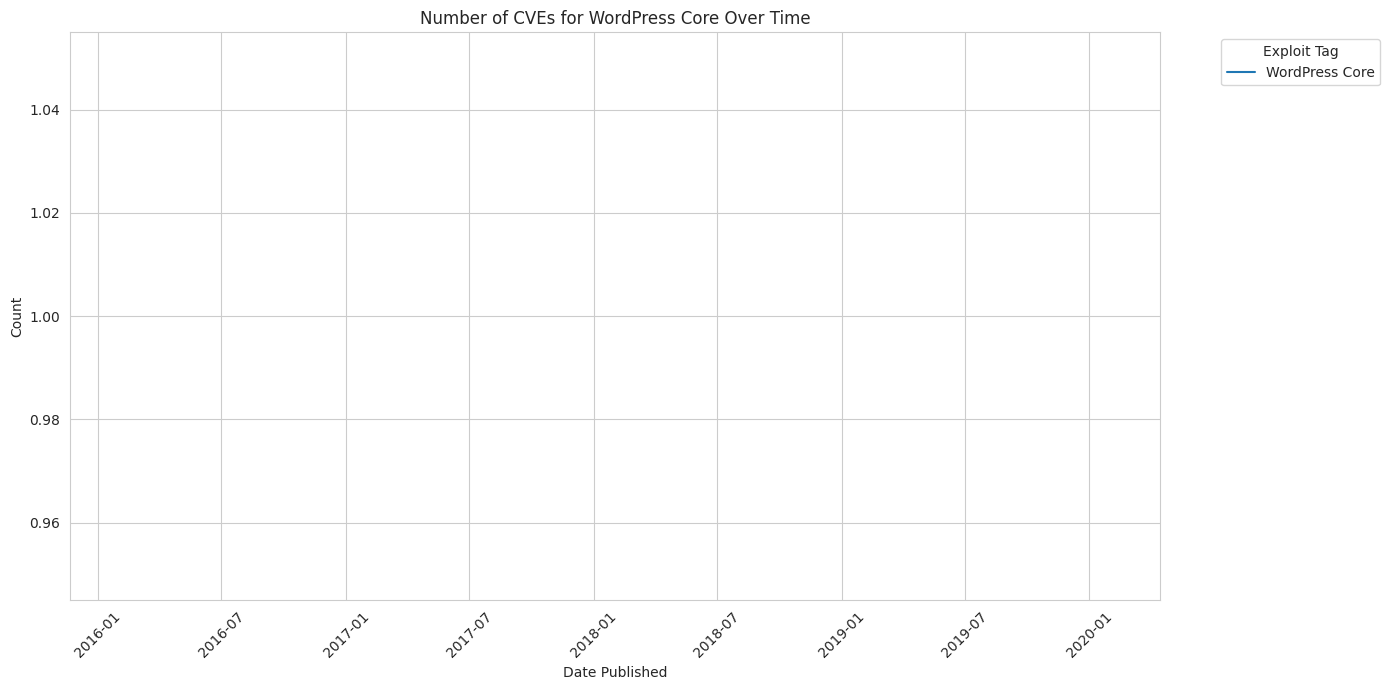

<Figure size 640x480 with 0 Axes>

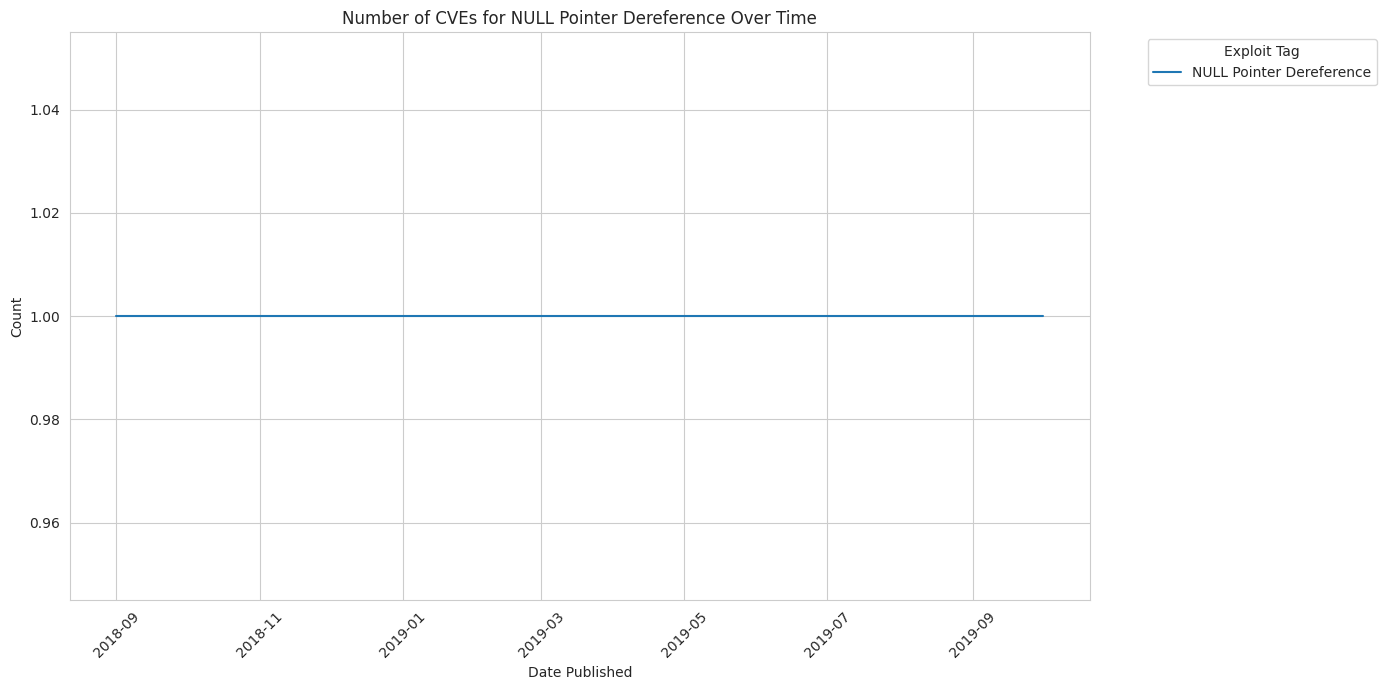

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime

from config.logger import logger
from src.infrastructure.mongodb_cve_repository import MongoDBCVERepository

cves_with_predicted_exploit_tag_repository = MongoDBCVERepository(
        collection_name=CVES_WITH_PREDICTED_EXPLOIT_TAG_COLLECTION
    )
cves = cves_with_predicted_exploit_tag_repository.find_all()
df = pd.DataFrame(list(cves))

df.loc[df['predicted_exploit_tag_confidence'] < MINIMUM_CONFIDENCE_THRESHOLD, 'predicted_exploit_tag'] = ''

df["exploit_tag_final"] = np.where(
    (df["exploit_tag_x"].isna()) | (df["exploit_tag_x"] == "") | (df["exploit_tag_x"] == "unknown"),
    df["predicted_exploit_tag"],
    df["exploit_tag_x"],
)

grouped_df = (
    df.groupby([df["date_published"].dt.to_period("M"), "exploit_tag_final"])
    .size()
    .reset_index(name="count")
)

grouped_df["date_published"] = grouped_df["date_published"].dt.to_timestamp()

for exploit_tag in grouped_df["exploit_tag_final"].unique():
    df_exploit = grouped_df[grouped_df["exploit_tag_final"] == exploit_tag]

    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_exploit, x="date_published", y="count", hue="exploit_tag_final")
    plt.title(f"Number of CVEs for {exploit_tag} Over Time")
    plt.xlabel("Date Published")
    plt.ylabel("Count")
    plt.legend(title="Exploit Tag", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.clf()

## Forecasting CVEs by Exploit Tag

Now, using a forecasting model we try to predict CVEs by Exploit Tag over time.

### Forecasting 2 years from now
This is the result:

[2024-08-18 12:02:18.704] ERROR [133421062832128] - Importing plotly failed. Interactive plots will not work.


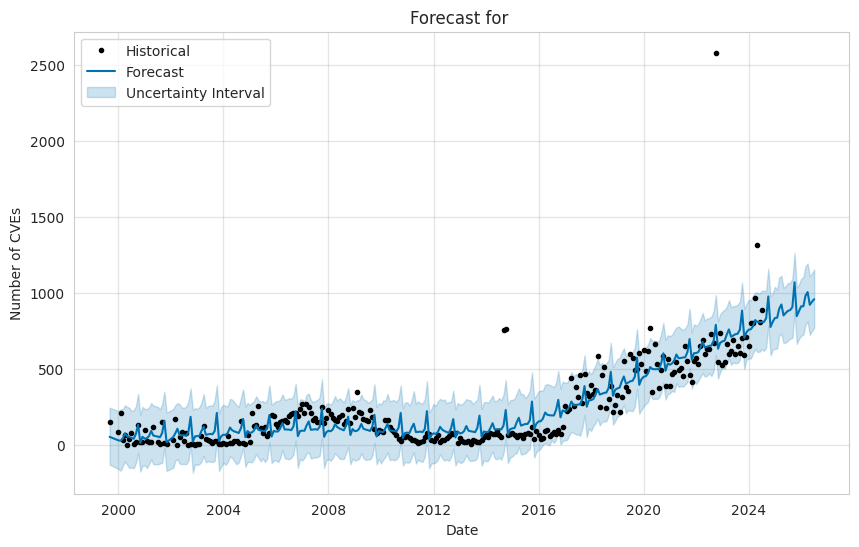

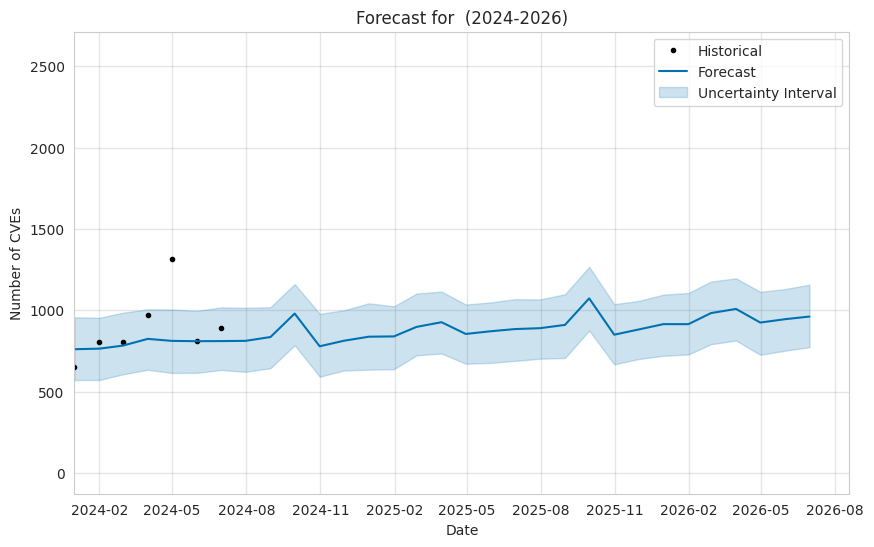

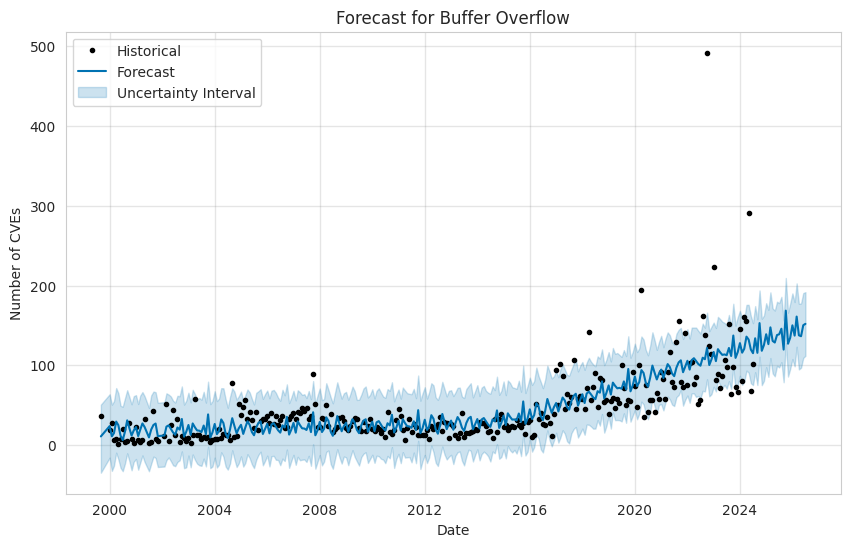

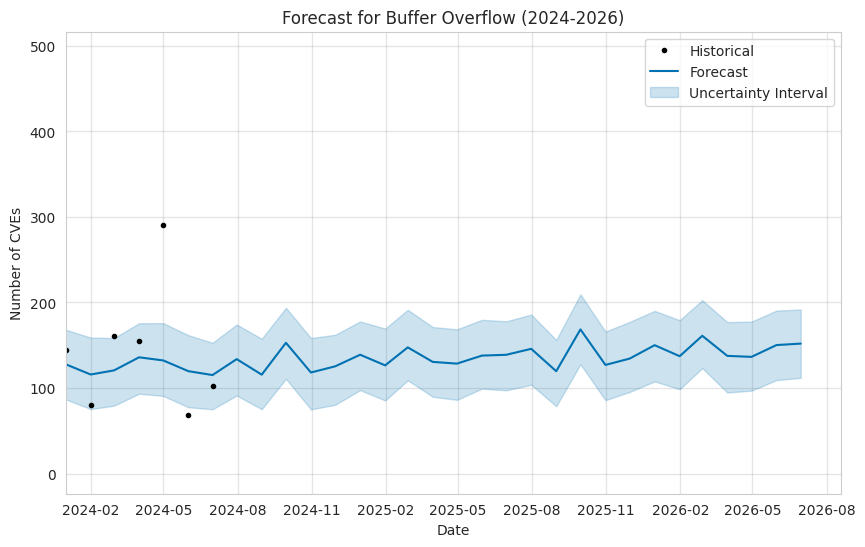

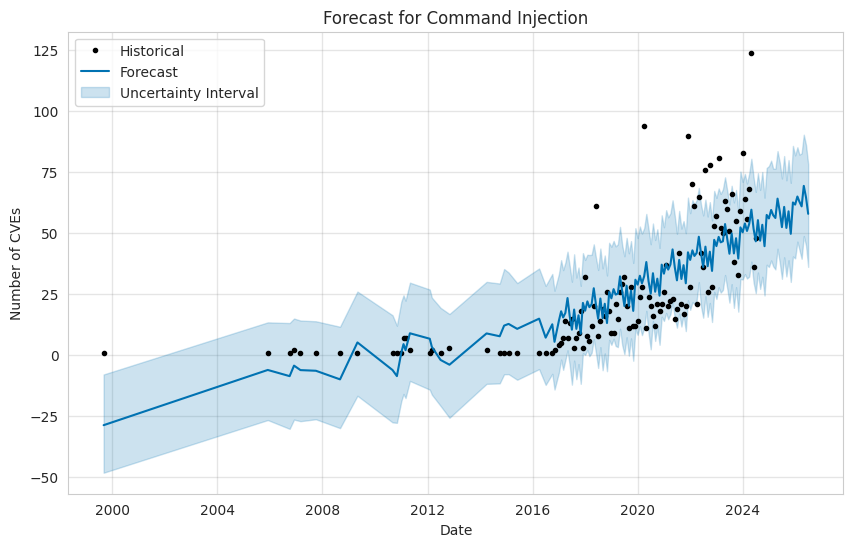

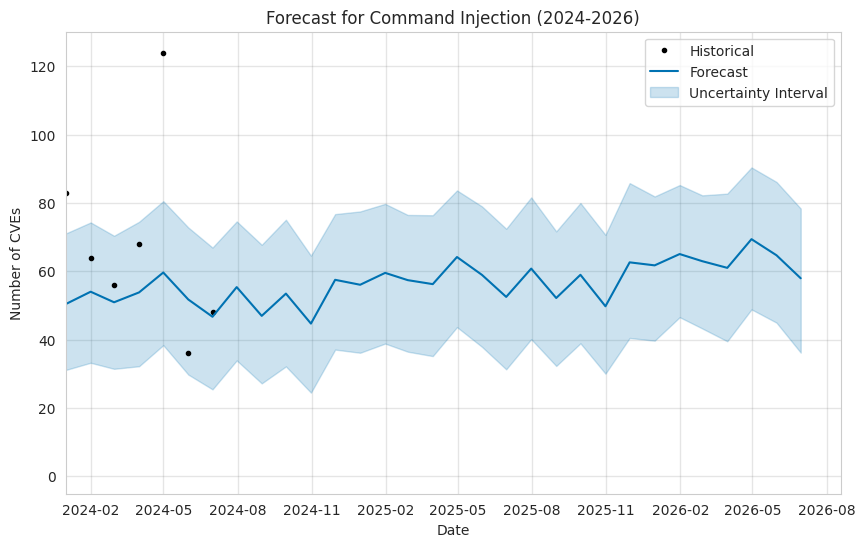

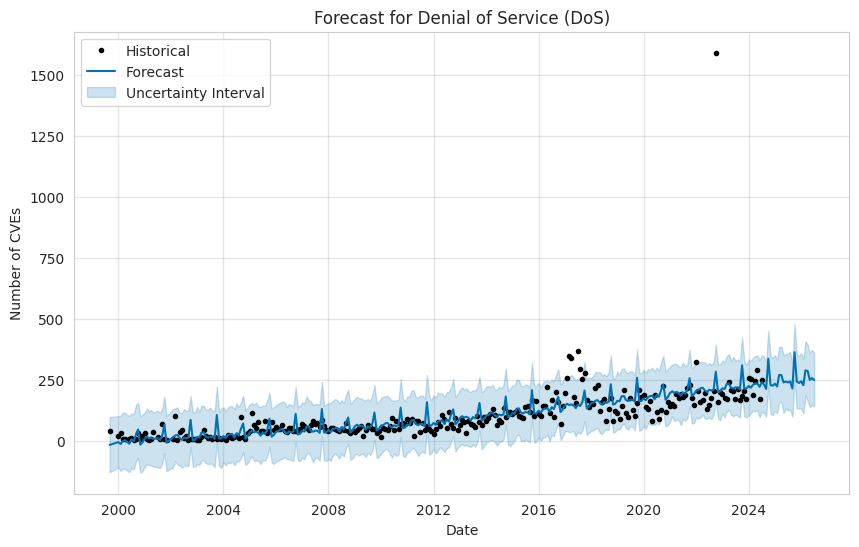

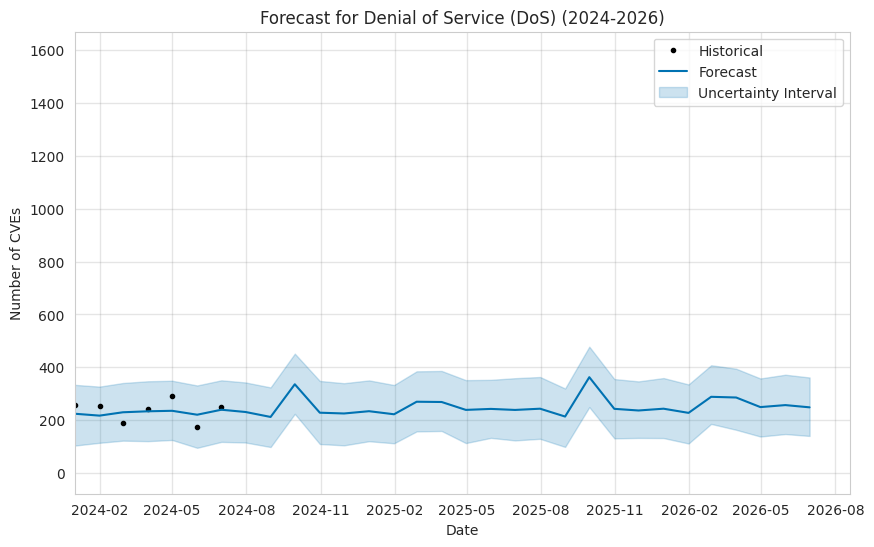

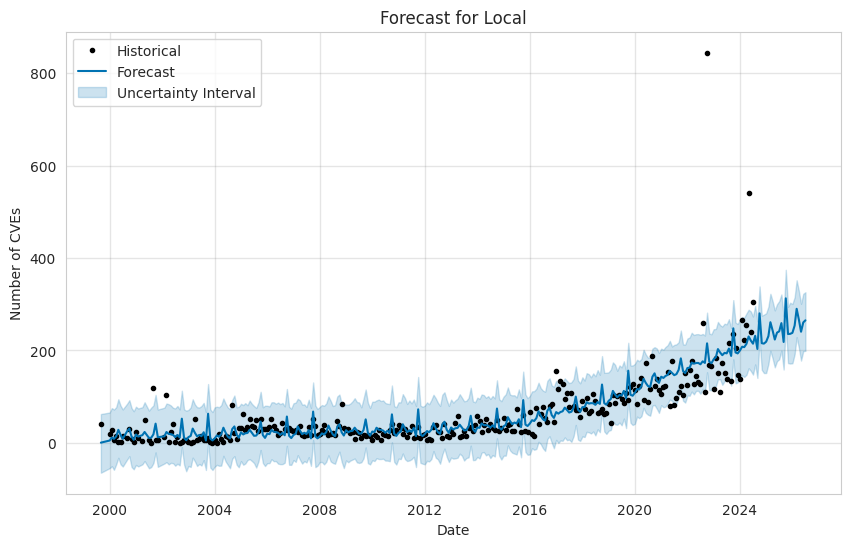

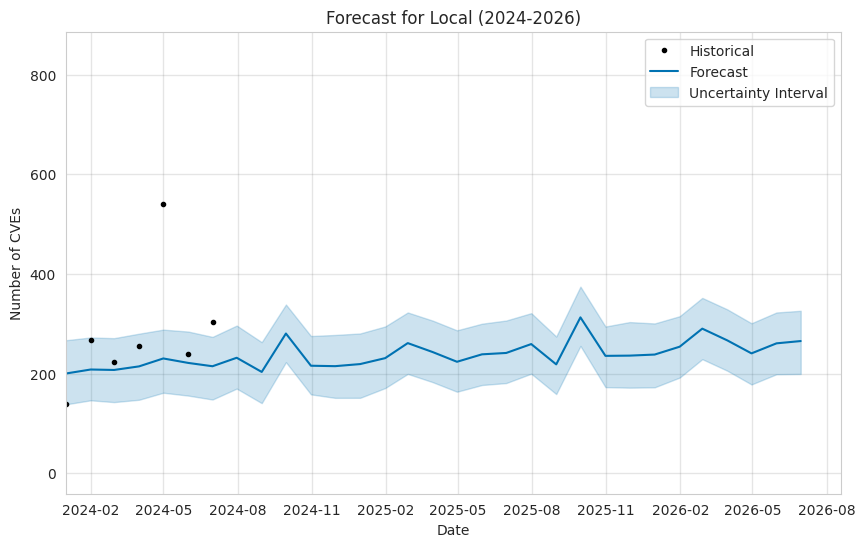

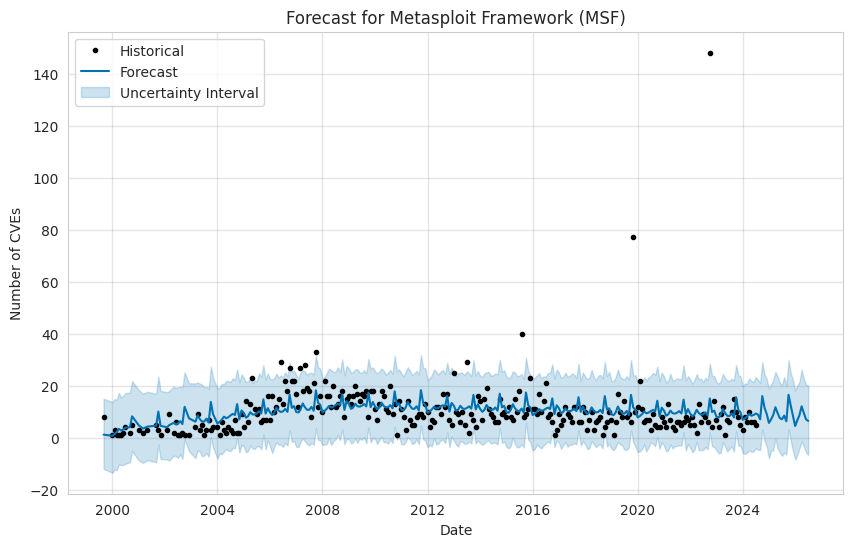

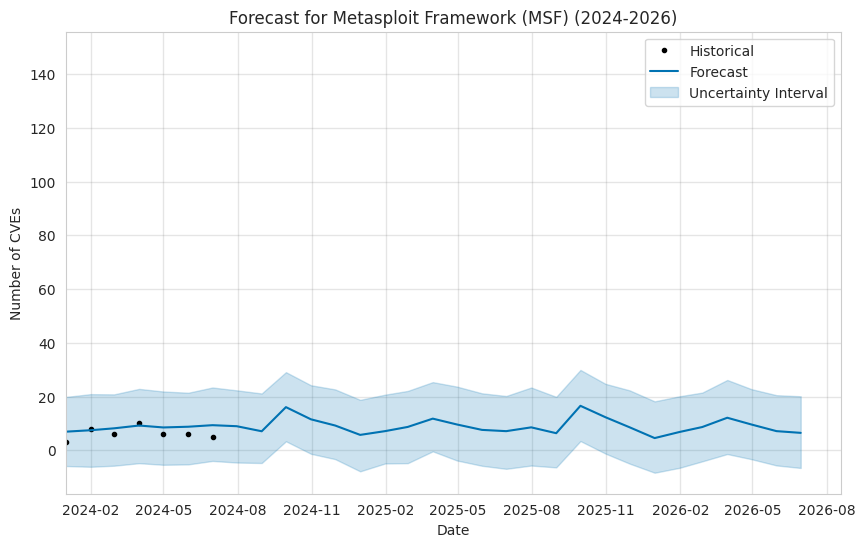

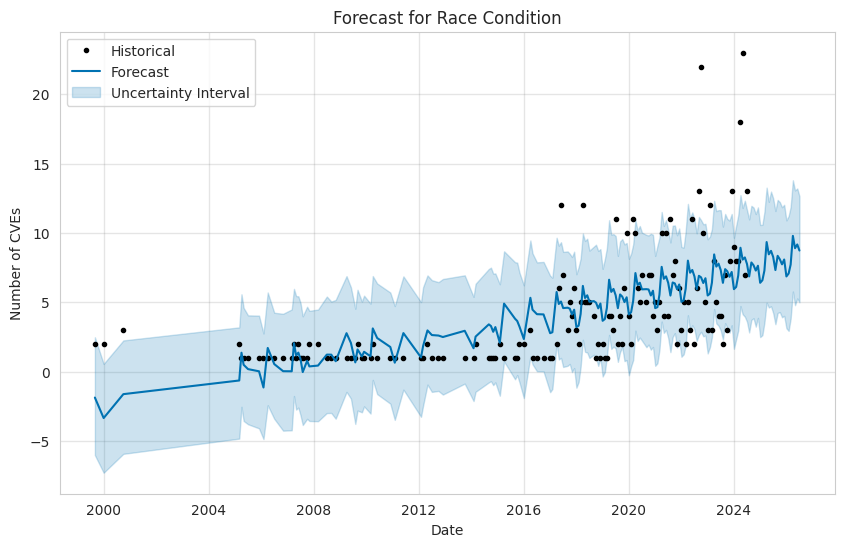

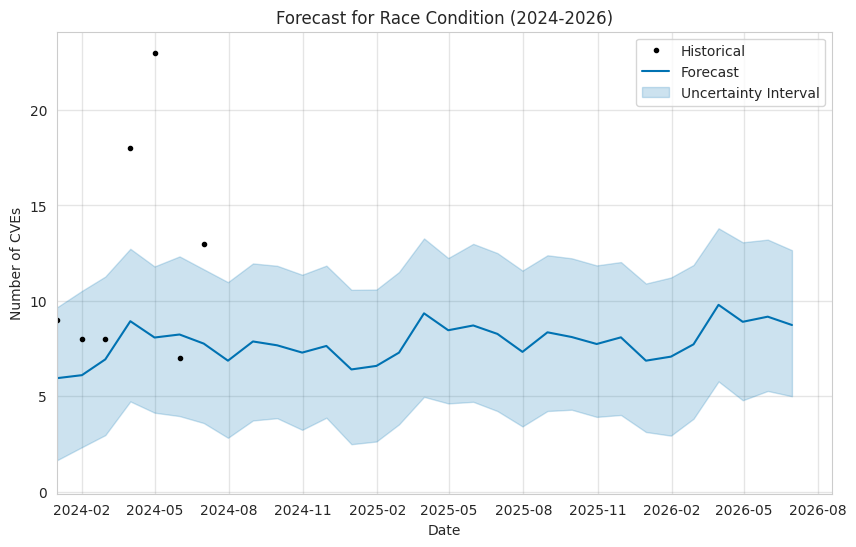

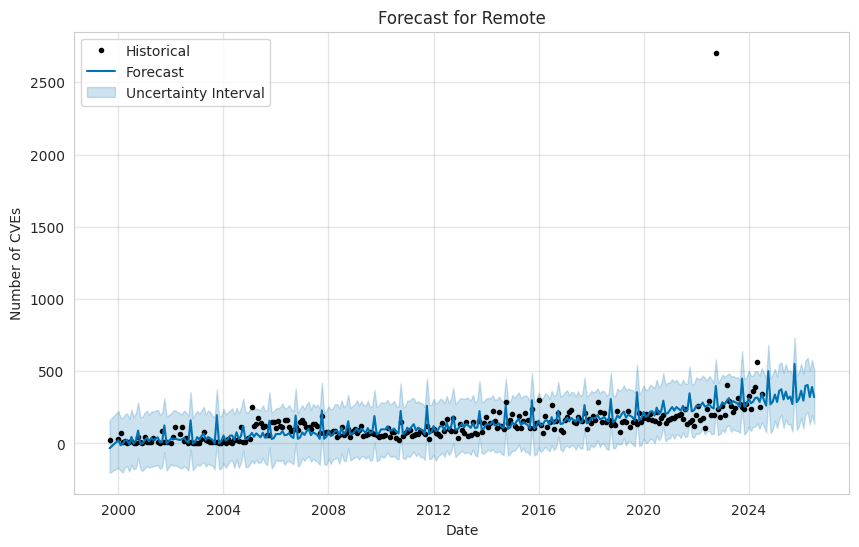

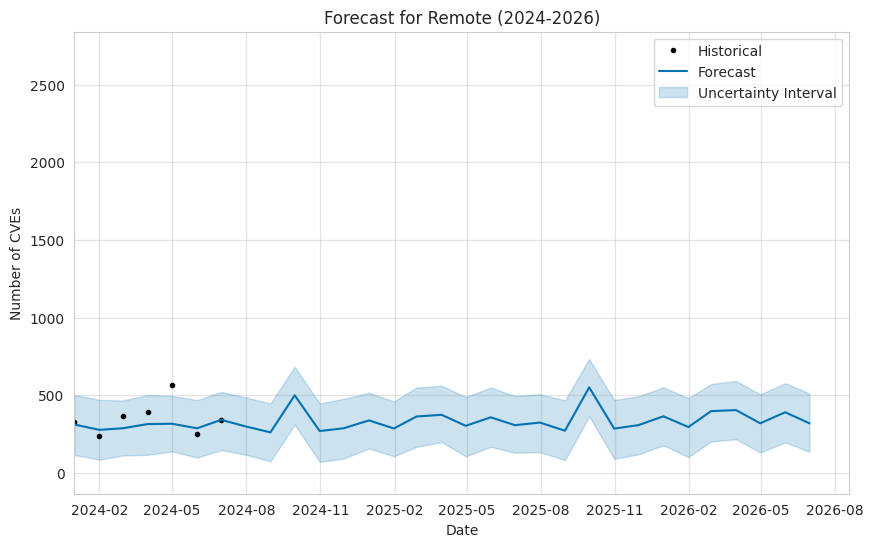

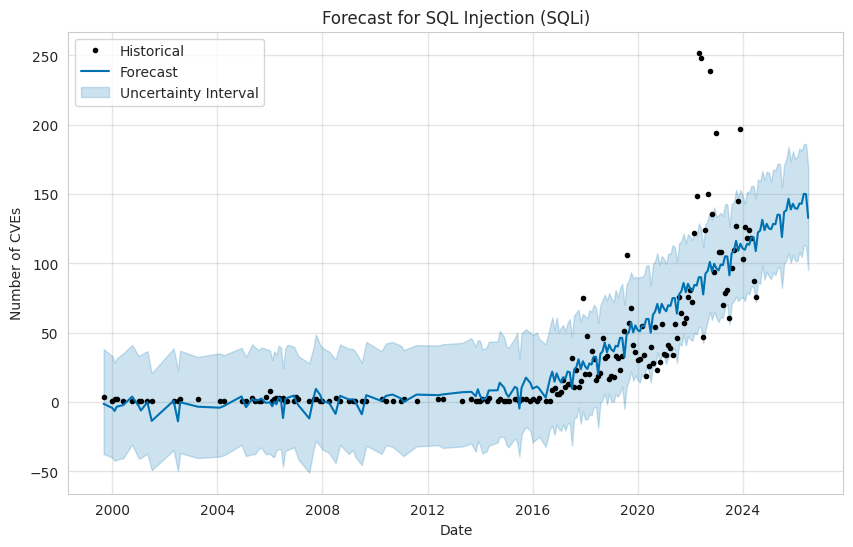

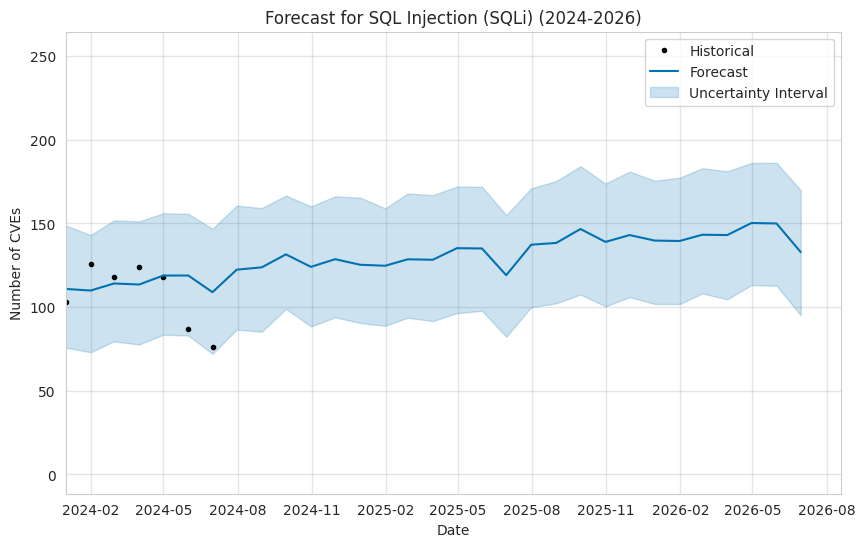

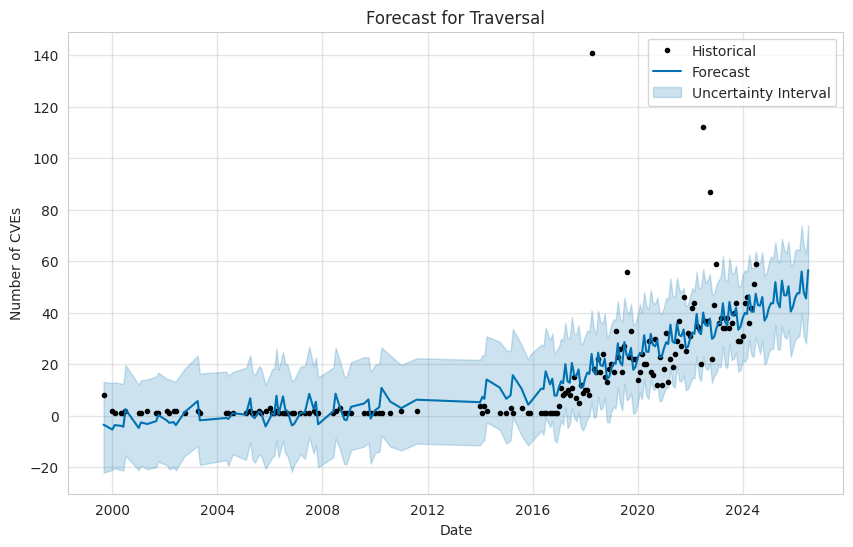

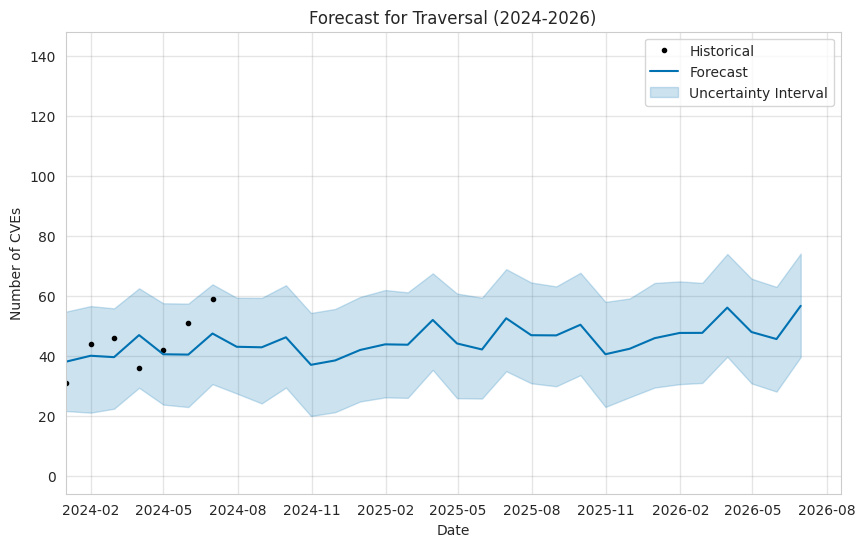

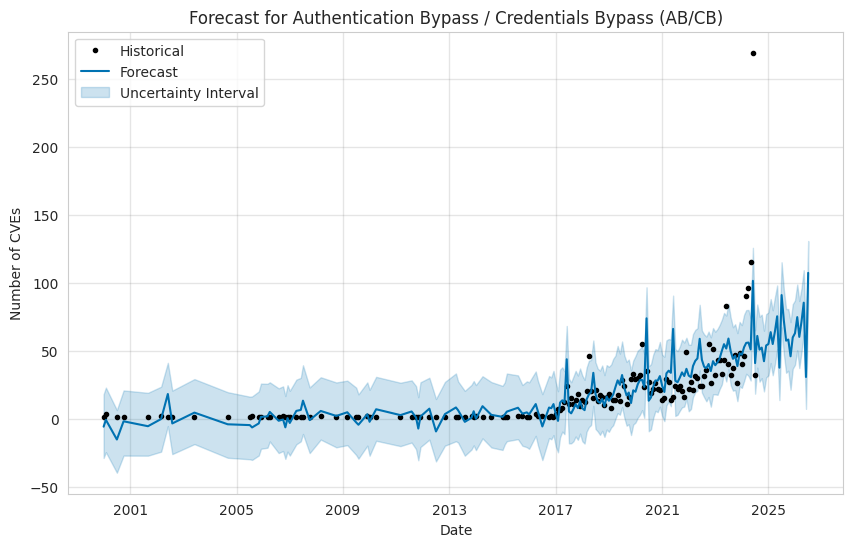

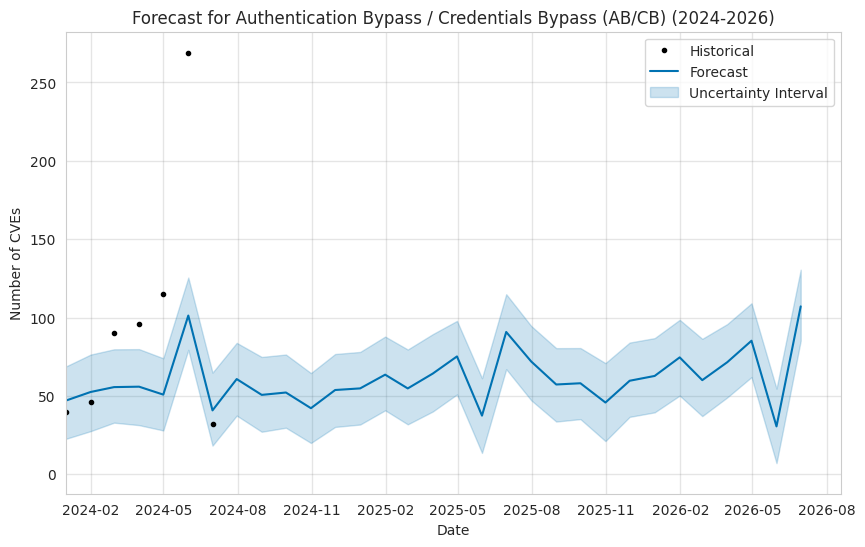

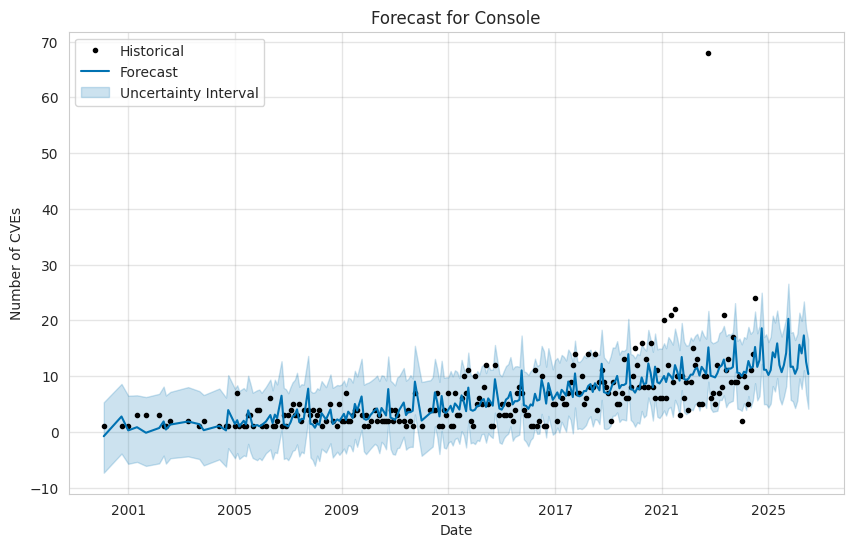

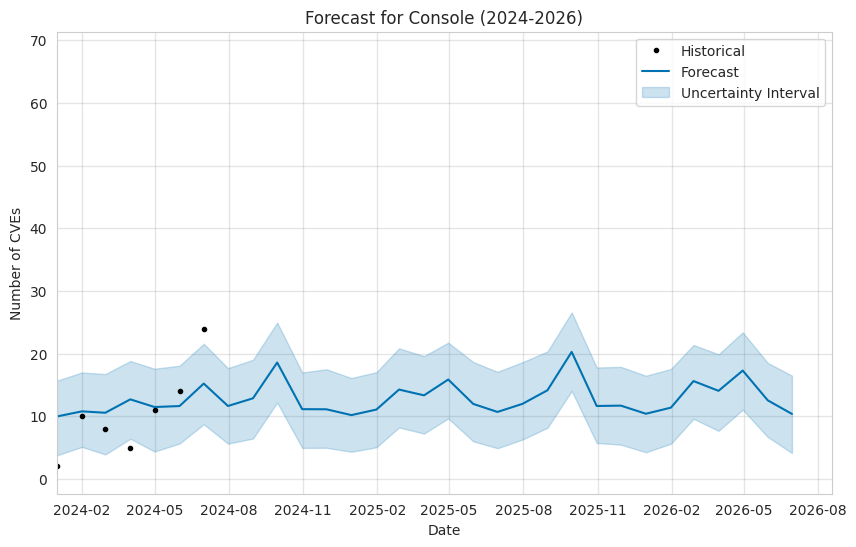

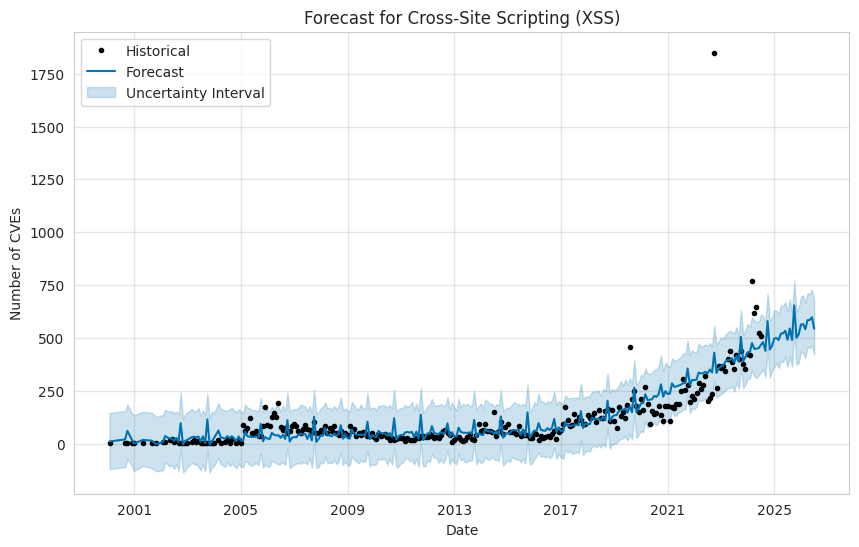

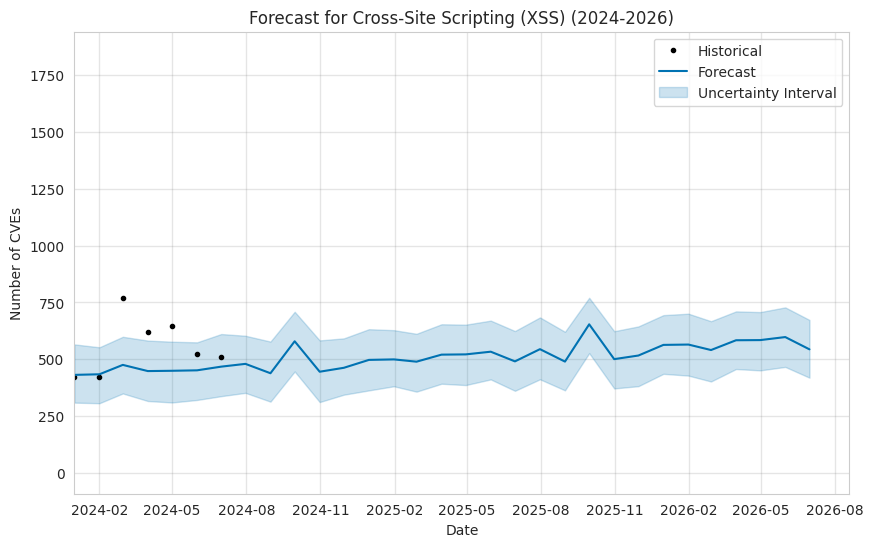

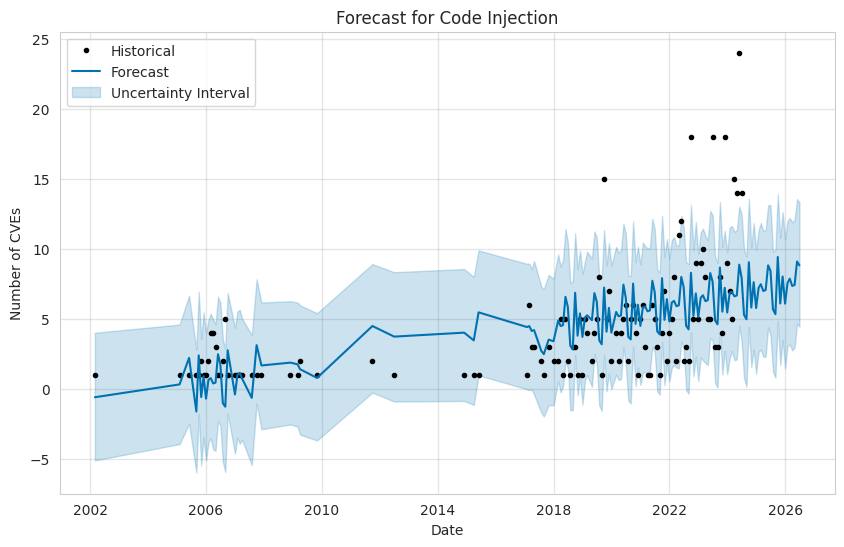

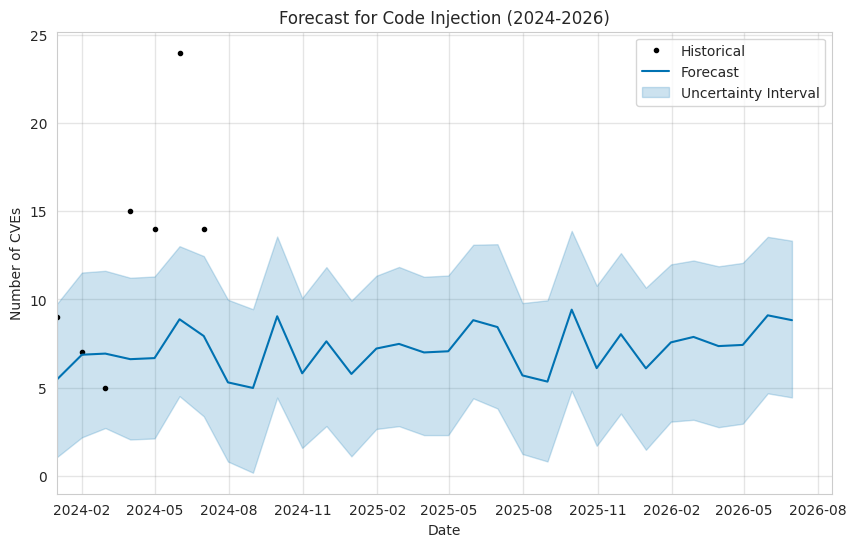

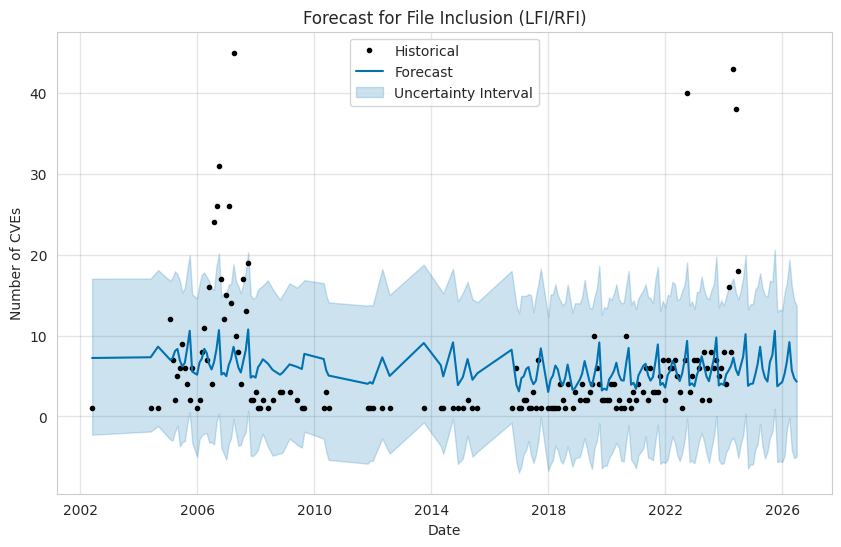

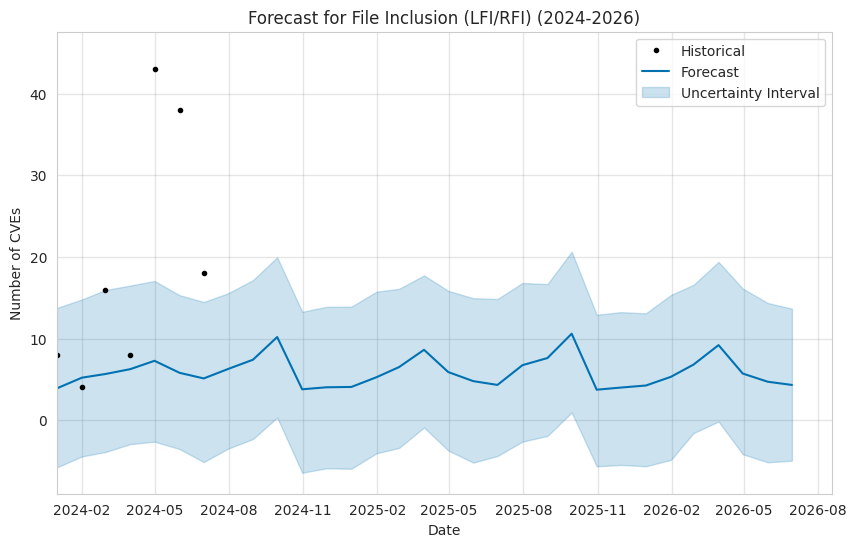

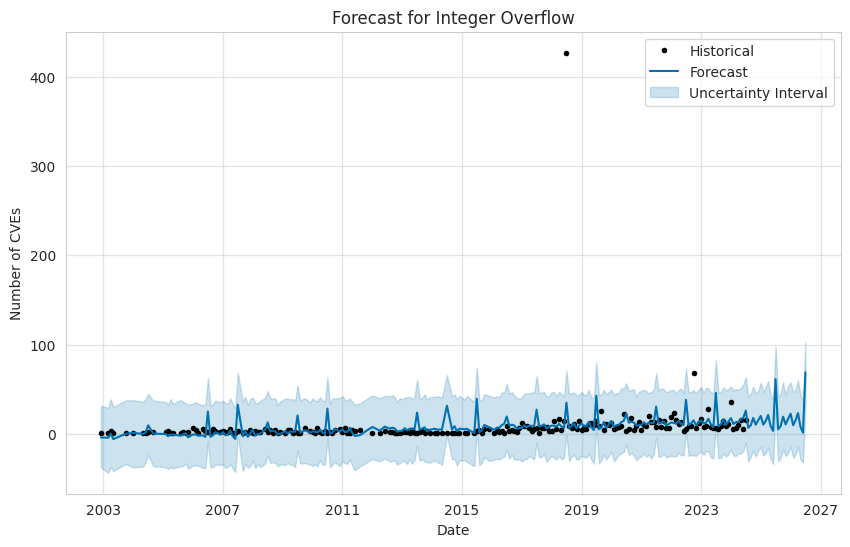

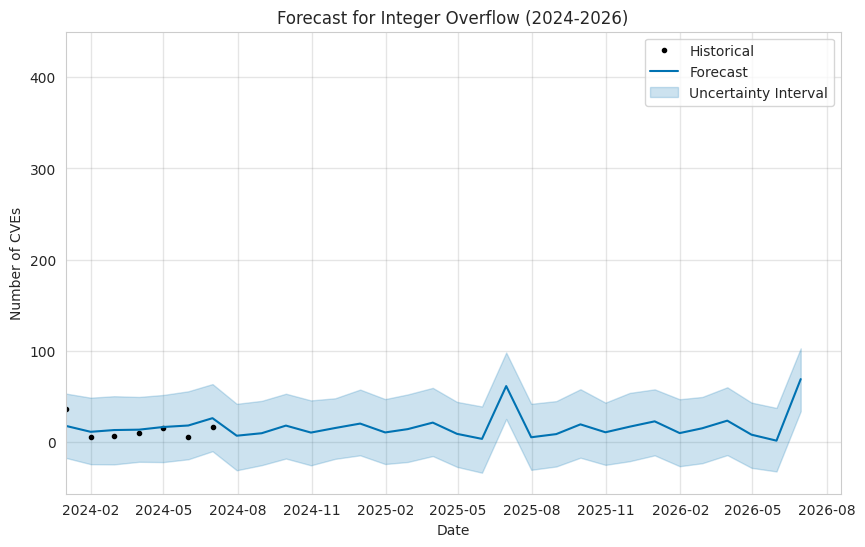

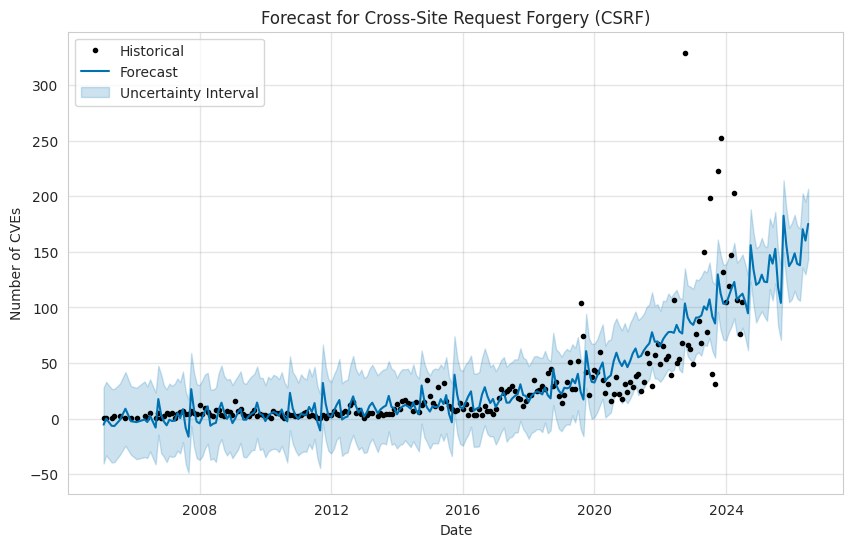

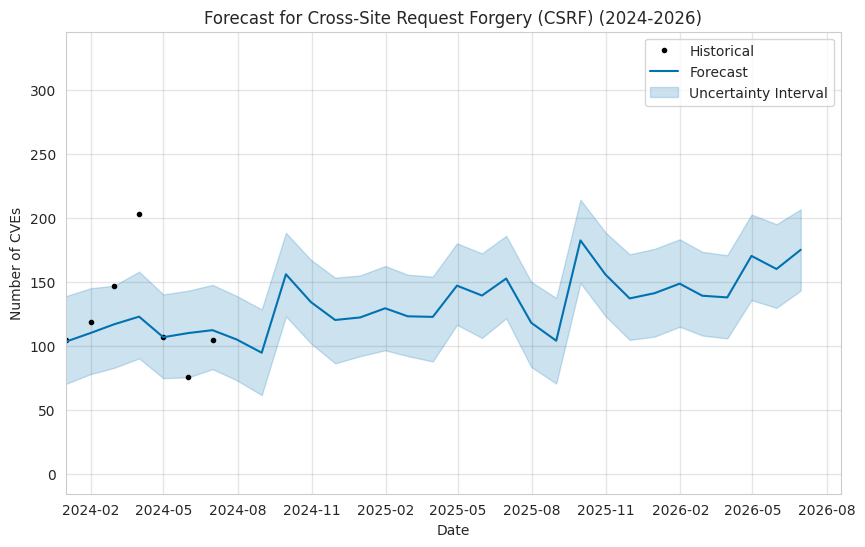

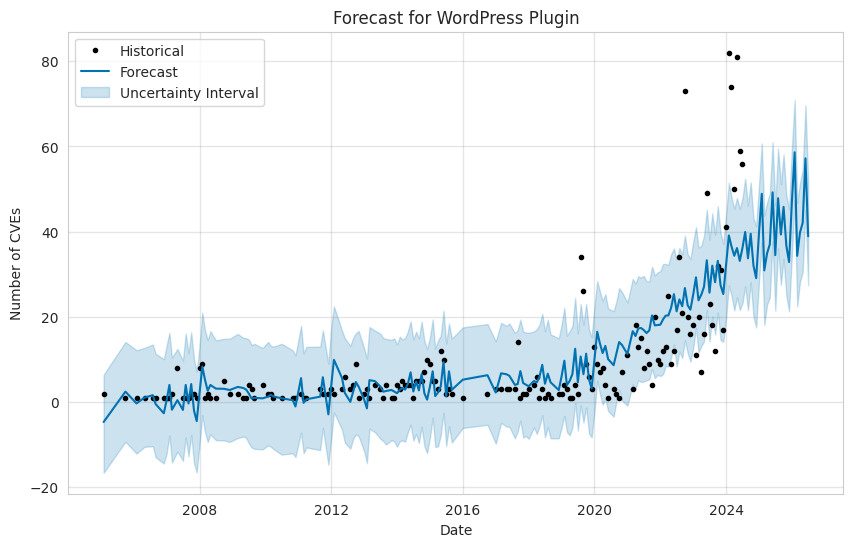

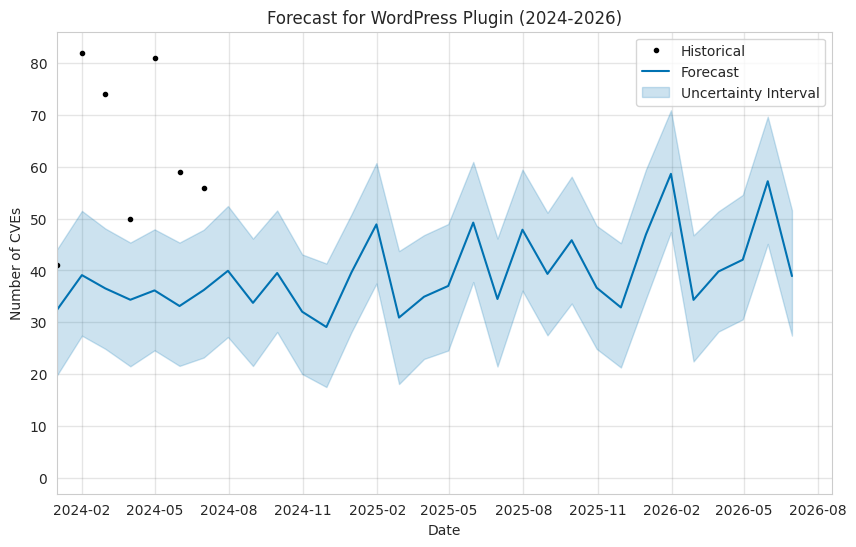

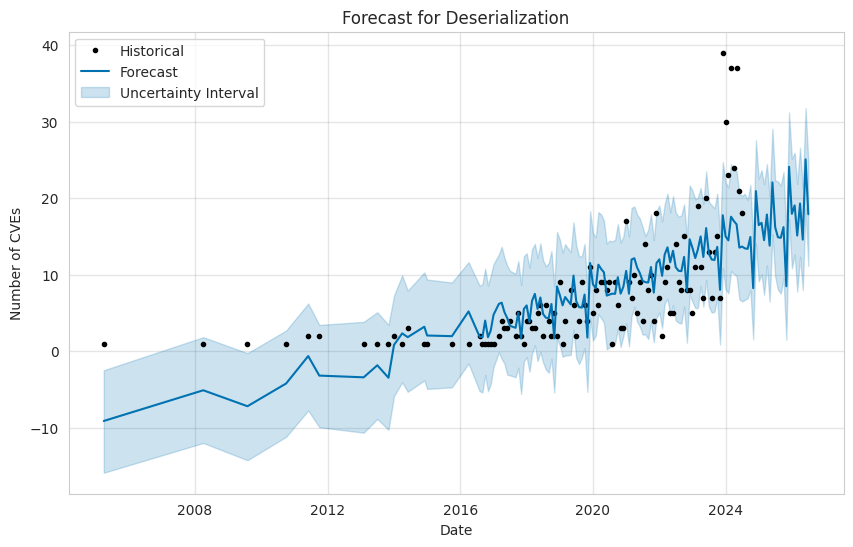

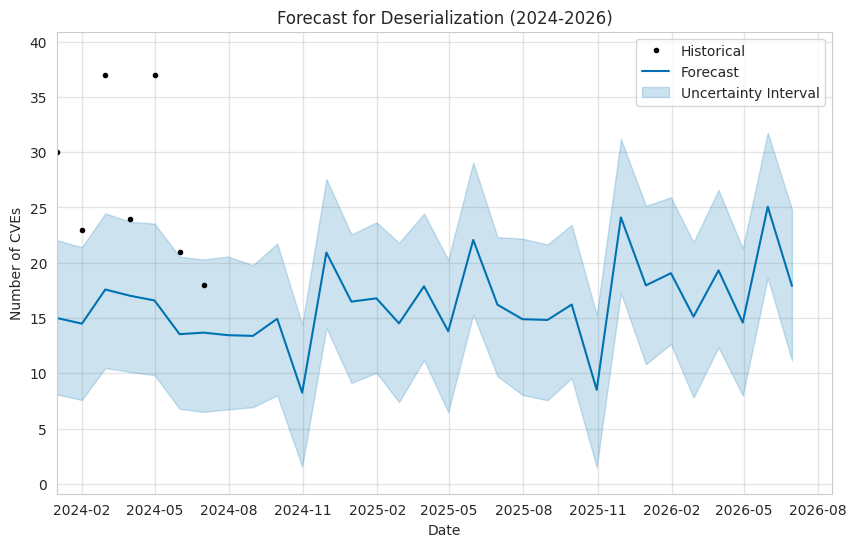

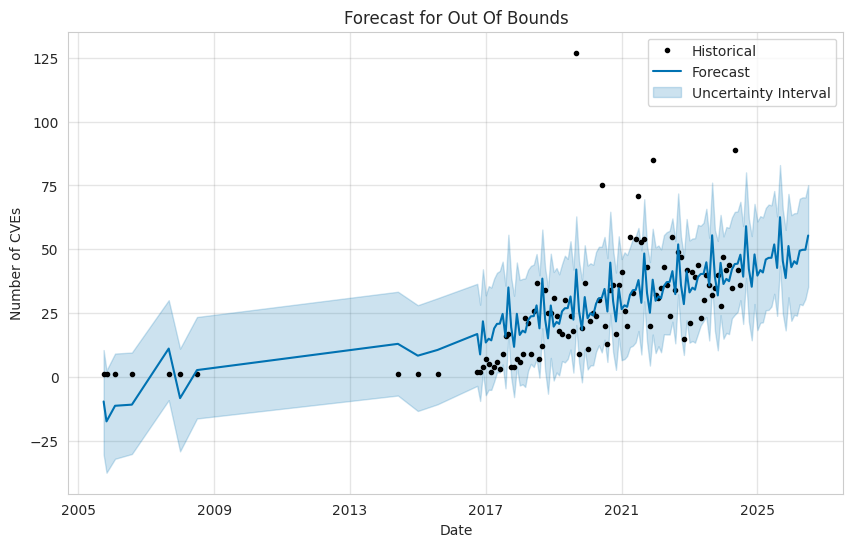

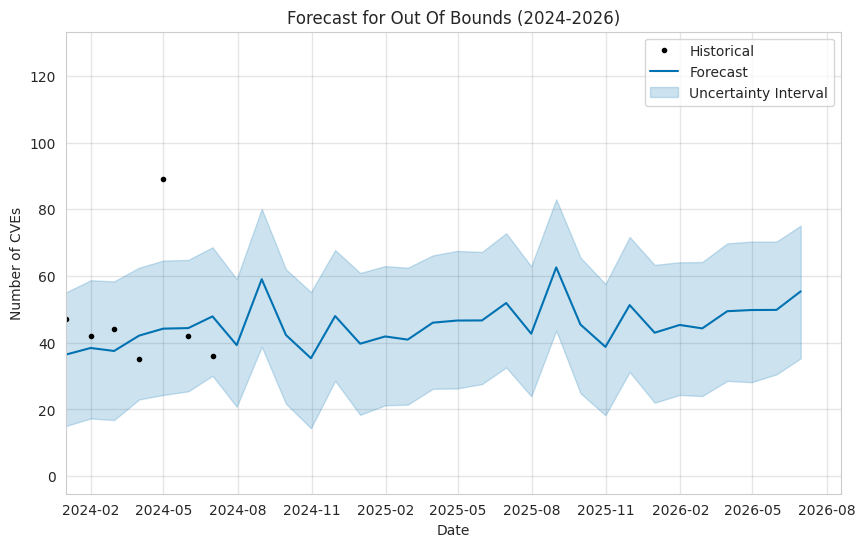

In [8]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from dateutil.relativedelta import relativedelta

from config.logger import logger

models = {}
forecast_dfs = {}

for exploit in grouped_df["exploit_tag_final"].unique():
    df_exploit = grouped_df[grouped_df["exploit_tag_final"] == exploit]

    if (
        df_exploit.shape[0] < 100
        or df_exploit["count"].isna().sum() >= df_exploit.shape[0] - 1
    ):
        logger.warning(f"Not enough data for {exploit}. Skipping this exploit tag.")
    else:

        df_prophet = df_exploit.rename(columns={"date_published": "ds", "count": "y"})[
            ["ds", "y"]
        ]

        model = Prophet(
            yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False
        )
        model.fit(df_prophet)
        models[exploit] = model

        future = model.make_future_dataframe(
            periods=24, freq="M"
        )

        forecast = model.predict(future)
        forecast_dfs[exploit] = forecast

        fig, ax = plt.subplots(figsize=(10, 6))
        model.plot(forecast, ax=ax)
        ax.set_title(f"Forecast for {exploit}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Number of CVEs")
        ax.legend(["Historical", "Forecast", "Uncertainty Interval"])
        plt.show()

        current_year = datetime.now().year
        final_year = current_year + 2
        forecast_filtered = forecast[
            (forecast['ds'].dt.year >= current_year) & (forecast['ds'].dt.year <= final_year)
        ]

        fig, ax = plt.subplots(figsize=(10, 6))
        model.plot(forecast_filtered, ax=ax)

        ax.set_xlim([datetime(current_year, 1, 1), (datetime.now() + relativedelta(years=2))])
        ax.set_title(f"Forecast for {exploit} ({current_year}-{final_year})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Number of CVEs")
        ax.legend(["Historical", "Forecast", "Uncertainty Interval"])
        plt.show()